In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import text as keras_text, sequence as keras_seq

Using TensorFlow backend.


In [7]:
from keras.models import Sequential,Model,Input,load_model
from keras.layers import LSTM,Dense,TimeDistributed,Activation,MaxPooling2D,Embedding,RepeatVector,Flatten,Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD

In [16]:
data=pd.read_csv('train-bp.csv')  ## read the file

In [17]:
#data.describe()functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions


In [18]:
seq=data["0"]    ## sequence 

In [19]:
y=data.iloc[:,1:]   ###### traget 

In [22]:
###### making 3 word fix sequence

In [23]:
sequence=[]
Length_seq=[]
for ix in range(len(seq)):
    inter_seq=[]
    Seq=seq[ix]
    le=len(Seq)
    k=0
    for ixx in range(int(le/3)):
        f=Seq[k:k+3]
        inter_seq.append(f)
        k=k+3
    Length_seq.append(len(inter_seq))   #### no word present in a sequence 
    sequence.append(inter_seq)

In [24]:
sequence=np.array(sequence)

In [28]:
print(sequence[0][:10])

['MNF', 'LWK', 'GRR', 'FLI', 'AGI', 'LPT', 'FEG', 'AAD', 'EIV', 'DKE']


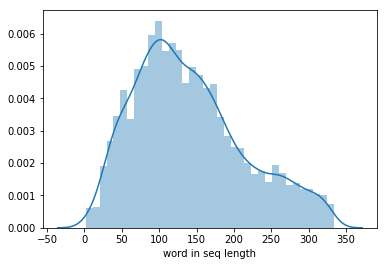

In [14]:
sns.distplot(Length_seq,axlabel="word in seq length")   #######  

In [45]:
#from gensim.models import Word2Vec

In [1]:
#model = Word2Vec(
 #       sequence,
  #      size=200,
   #     window=3,
    #    min_count=1,
     #   workers=10,sg=1)
#model.train(sequence, total_examples=len(sequence), epochs=10)

In [23]:
#words = list(model.wv.vocab)
#print(words)

In [46]:
#model.wv.save_word2vec_format('skip_gram_3_model.txt',binary=False)
# load model


In [2]:
#embeddings_index = dict()
#f = open('skip_gram_3_model.txt')
#for line in f:
#	values = line.split()
#	word = values[0]
#	coefs = np.asarray(values[1:], dtype='float32')
#	embeddings_index[word] = coefs
#f.close()
#print('Loaded %s word vectors.' % len(embeddings_index))


In [15]:
from keras.preprocessing.text import Tokenizer    ##### tokenize and padding 
tok = Tokenizer(char_level = False)
t=tok.fit_on_texts(sequence)
list_tokenized_train = tok.texts_to_sequences(sequence)
X = keras_seq.pad_sequences(list_tokenized_train, maxlen=350,padding="post") #maxlen padding 100

In [49]:
#embedding_matrix = np.zeros((8001, 100))
#for word, i in tok.word_index.items():
#	embedding_vector = embeddings_index.get(word)
#	if embedding_vector is not None:
#		embedding_matrix[i] = embedding_vector

In [3]:
"""from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
words=words[:10]
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()   """

'from gensim.models import Word2Vec\nfrom sklearn.decomposition import PCA\nfrom matplotlib import pyplot\n\n# fit a 2d PCA model to the vectors\nX = model[model.wv.vocab]\npca = PCA(n_components=2)\nresult = pca.fit_transform(X)\n# create a scatter plot of the projection\npyplot.scatter(result[:, 0], result[:, 1])\nwords = list(model.wv.vocab)\nwords=words[:10]\nfor i, word in enumerate(words):\n\tpyplot.annotate(word, xy=(result[i, 0], result[i, 1]))\npyplot.show()   '

In [9]:
from keras.callbacks import EarlyStopping,Callback


In [10]:
def getweights(model):                                  #######  get weight metrix every epochs
    w=model.get_layer(index=1).get_weights()[0]
    print("embedding")
    print(w)   
    w=model.get_layer(index=1).get_weights()[1]
    print("LSTM")
    print(w)
    w=model.get_layer(index=1).get_weights()[2]
    print("dense")
    print(w)

from keras import backend as K
    
def getoutput(model):     ############# get ouutput metrix after every epochs
    
    inp = model.input                                           # input placeholder
    outputs = [layer.output for layer in model.layers]          # all layer outputs
    functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

# Testing
    test = np.random.random(max_len)[np.newaxis,...]
    layer_outs = [func([test, 1.]) for func in functors[0]]
    print("output")
    print(layer_outs)

In [12]:
from keras.callbacks import LambdaCallback
pw = LambdaCallback(on_epoch_end=lambda batch, logs:getweights(model))
out = LambdaCallback(on_epoch_end=lambda batch, logs:getoutput(model))

In [13]:
max_len=350
output=932

In [14]:
model= Sequential()
model.add(Embedding(8001,100,input_length=max_len,trainable=True))
model.add(LSTM(64,return_sequences=False))
model.add(Dropout(0.2))
#model.add(Flatten())
model.add(Dense(932,activation="sigmoid"))
model.compile( optimizer = 'rmsprop', loss = "binary_crossentropy",metrics = ['accuracy'] )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 100)          800100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 932)               60580     
Total params: 902,920
Trainable params: 902,920
Non-trainable params: 0
_________________________________________________________________


In [17]:
history=model.fit(X,y, batch_size =128,epochs =300,class_weight='balanced',validation_split=0.35,shuffle=True,callbacks=[pw])

Train on 23647 samples, validate on 12733 samples
Epoch 1/500
23647/23647 [==============================] - 100s 4ms/step - loss: 0.1577 - acc: 0.9627 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[ 0.04840998  0.08138335 -0.10710852 ...  0.02849966  0.01640376
   0.12292346]
 [ 0.04367676 -0.00827236  0.07333081 ...  0.05091657 -0.07733617
  -0.05345358]
 [-0.0946527   0.00724279  0.0078496  ...  0.10160974 -0.06043201
   0.15707763]
 ...
 [ 0.12602091  0.06489238 -0.01201935 ... -0.02095357  0.07773806
  -0.01221271]
 [-0.00400775 -0.10664369  0.08022289 ...  0.06115166  0.13697171
   0.05471778]
 [ 0.10388743  0.04610727  0.05297854 ... -0.09113459 -0.13025698
  -0.04234228]]
LSTM
[[-0.00820597  0.00285968 -0.08349665 ... -0.02678023 -0.06696301
  -0.0540817 ]
 [-0.06578734  0.06376179  0.10378426 ... -0.06978371  0.15003803
  -0.0843235 ]
 [-0.00909365  0.00620483 -0.08024006 ... -0.12046806 -0.02191466
  -0.02615907]
 ...
 [ 0.0304428  -0.01839438  0.03336089 ... -0.02378081 -0

23647/23647 [==============================] - 96s 4ms/step - loss: 0.1182 - acc: 0.9680 - val_loss: 0.1171 - val_acc: 0.9680
embedding
[[ 0.05033695  0.08138704 -0.10710792 ...  0.03134738  0.01892247
   0.12292366]
 [ 0.04208357 -0.00827534  0.07333035 ...  0.04816036 -0.07970158
  -0.05345373]
 [-0.0938902   0.00724372  0.00784983 ...  0.10395314 -0.05841402
   0.15707761]
 ...
 [ 0.12673645  0.06489323 -0.01201907 ... -0.01870921  0.07962916
  -0.0122127 ]
 [-0.00280958 -0.10664211  0.08022314 ...  0.06371648  0.13906123
   0.05471788]
 [ 0.10280357  0.04610546  0.05297828 ... -0.09370159 -0.13242123
  -0.04234229]]
LSTM
[[-0.01306999  0.00281563 -0.08350421 ... -0.02987748 -0.07003769
  -0.05406982]
 [-0.06091809  0.06380583  0.10379183 ... -0.06668543  0.1531128
  -0.08433537]
 [-0.01396266  0.0061608  -0.0802476  ... -0.12356576 -0.02498958
  -0.02614731]
 ...
 [ 0.02558205 -0.01843844  0.03335334 ... -0.02687857 -0.10201462
  -0.14044346]
 [-0.07123435 -0.02840776 -0.03620533 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1181 - acc: 0.9680 - val_loss: 0.1171 - val_acc: 0.9681
embedding
[[ 0.05051517  0.08142921 -0.10701475 ...  0.03528807  0.02187527
   0.12770812]
 [ 0.04191471 -0.00831432  0.0732477  ...  0.04420138 -0.08262467
  -0.05828118]
 [-0.09386615  0.00724985  0.00786751 ...  0.10934583 -0.05610662
   0.1614834 ]
 ...
 [ 0.12675092  0.06489427 -0.01200912 ... -0.01737406  0.08161408
  -0.01095195]
 [-0.00274108 -0.1066303   0.08026499 ...  0.06855068  0.14180532
   0.05942113]
 [ 0.10271118  0.04608449  0.05292801 ... -0.09830578 -0.13521744
  -0.04704997]]
LSTM
[[-0.01459922  0.00229195 -0.08445688 ... -0.03279131 -0.07317289
  -0.05887628]
 [-0.05938752  0.06432979  0.10474552 ... -0.06377248  0.15624793
  -0.07952967]
 [-0.01549514  0.00563642 -0.08120268 ... -0.12647778 -0.02812486
  -0.03095213]
 ...
 [ 0.02411862 -0.01895199  0.03243699 ... -0.02991517 -0.10514889
  -0.14526084]
 [-0.0718217  -0.02860046 -0.03670447 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1181 - acc: 0.9680 - val_loss: 0.1171 - val_acc: 0.9681
embedding
[[ 0.05143133  0.08144213 -0.10700724 ...  0.03808741  0.02400405
   0.12770809]
 [ 0.04089921 -0.00832906  0.07323876 ...  0.04136503 -0.08481283
  -0.0582808 ]
 [-0.0939486   0.00724914  0.00786691 ...  0.10822571 -0.05629245
   0.16148373]
 ...
 [ 0.1268355   0.06489655 -0.01200754 ... -0.01592069  0.08151629
  -0.01095181]
 [-0.00300346 -0.10663172  0.08026404 ...  0.06652787  0.14077243
   0.05942132]
 [ 0.10242562  0.04608008  0.05292571 ... -0.10057315 -0.13631712
  -0.04704986]]
LSTM
[[-0.01720625  0.00212096 -0.08456008 ... -0.03590725 -0.07619609
  -0.05882412]
 [-0.05677425  0.06450111  0.10484888 ... -0.06065661  0.15927126
  -0.07958174]
 [-0.01810798  0.00546516 -0.081306   ... -0.12959349 -0.03114821
  -0.03089957]
 ...
 [ 0.02150737 -0.01912325  0.0323336  ... -0.03303079 -0.10817236
  -0.14520851]
 [-0.07278574 -0.02862553 -0.03671727 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1180 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[ 0.02907727  0.08144717 -0.10699629 ...  0.03808752  0.02400409
   0.12770829]
 [ 0.06257597 -0.00833508  0.07322684 ...  0.04136507 -0.08481283
  -0.05828064]
 [-0.10099618  0.00724809  0.00786555 ...  0.10822563 -0.05629249
   0.16148353]
 ...
 [ 0.12903064  0.06489692 -0.01200735 ... -0.0159207   0.0815163
  -0.01095176]
 [ 0.01065602 -0.10663333  0.08026058 ...  0.06652791  0.14077245
   0.05942148]
 [ 0.11864231  0.04607867  0.05292309 ... -0.10057309 -0.13631709
  -0.04704969]]
LSTM
[[ 0.01446613  0.00205227 -0.08467451 ... -0.03589716 -0.07619286
  -0.05878701]
 [-0.08739205  0.06456663  0.10497443 ... -0.06067174  0.15926623
  -0.07963013]
 [ 0.01242802  0.00539913 -0.08143298 ... -0.12957835 -0.03114318
  -0.03085082]
 ...
 [ 0.05204357 -0.01918921  0.03220663 ... -0.03301525 -0.10816722
  -0.14515896]
 [-0.04291473 -0.02862295 -0.03673277 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1180 - acc: 0.9680 - val_loss: 0.1169 - val_acc: 0.9681
embedding
[[ 0.02167135  0.08221275 -0.10699829 ...  0.04083568  0.02400409
   0.12852684]
 [ 0.0699419  -0.00929285  0.07322842 ...  0.03869401 -0.08481283
  -0.05898428]
 [-0.11566904  0.00648578  0.00786571 ...  0.10721967 -0.05629247
   0.16140777]
 ...
 [ 0.13226105  0.06445429 -0.01200724 ... -0.01756712  0.08151627
  -0.01112274]
 [ 0.01539832 -0.10759936  0.08026105 ...  0.06433724  0.14077246
   0.05908625]
 [ 0.1258753   0.04513039  0.05292361 ... -0.10280731 -0.13631706
  -0.0474053 ]]
LSTM
[[ 0.02876288  0.00359715 -0.08466306 ... -0.03885072 -0.07619153
  -0.06014578]
 [-0.09509861  0.06148505  0.10495422 ... -0.05757329  0.15926301
  -0.07724891]
 [ 0.02010662  0.00847312 -0.08141277 ... -0.13267663 -0.03114002
  -0.03323171]
 ...
 [ 0.05972428 -0.01610941  0.03222676 ... -0.03611356 -0.10816407
  -0.14753953]
 [-0.03062907 -0.02881107 -0.03672625 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1180 - acc: 0.9680 - val_loss: 0.1169 - val_acc: 0.9681
embedding
[[ 0.01242856  0.0709519  -0.10700586 ...  0.0408357   0.02400413
   0.128527  ]
 [ 0.0790553   0.0013794   0.07323369 ...  0.03869399 -0.08481281
  -0.05898432]
 [-0.10638063  0.01546519  0.00786772 ...  0.1072197  -0.05629246
   0.1614078 ]
 ...
 [ 0.13200606  0.0614685  -0.01200698 ... -0.01756714  0.08151622
  -0.01112272]
 [ 0.02335228 -0.09932726  0.08026347 ...  0.06433725  0.14077252
   0.05908636]
 [ 0.13419574  0.05353779  0.05292607 ... -0.10280733 -0.136317
  -0.04740538]]
LSTM
[[ 4.39575352e-02  2.27806158e-02 -8.46334174e-02 ... -3.88501436e-02
  -7.61878118e-02 -6.01424128e-02]
 [-1.06186695e-01  4.41298150e-02  1.04888089e-01 ... -5.75747937e-02
   1.59253612e-01 -7.72573650e-02]
 [ 3.01246829e-02  2.46315263e-02 -8.13460797e-02 ... -1.32674918e-01
  -3.11300736e-02 -3.32226828e-02]
 ...
 [ 6.97424188e-02  4.90052626e-05  3.22935432e-02

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[-0.00334921  0.06035173 -0.1070144  ...  0.04083586  0.02853472
   0.12852705]
 [ 0.0944183   0.01152074  0.07323953 ...  0.03869398 -0.08897497
  -0.05898429]
 [-0.09426867  0.02335235  0.00786913 ...  0.10721965 -0.05906385
   0.16140784]
 ...
 [ 0.13984457  0.0637342  -0.01200741 ... -0.01756726  0.08038372
  -0.01112271]
 [ 0.03738543 -0.09008982  0.08026545 ...  0.06433728  0.13743636
   0.05908632]
 [ 0.14849669  0.0627021   0.0529289  ... -0.10280741 -0.13927466
  -0.04740533]]
LSTM
[[ 0.06646462  0.04084745 -0.08460464 ... -0.03885031 -0.0808282
  -0.06014041]
 [-0.12731539  0.02895314  0.10479804 ... -0.05757397  0.16486877
  -0.07726518]
 [ 0.04696075  0.03599738 -0.08127167 ... -0.1326762  -0.03696167
  -0.03321321]
 ...
 [ 0.08657736  0.01141411  0.0323679  ... -0.0361133  -0.11398575
  -0.14752087]
 [ 0.00481268  0.00357582 -0.03668686 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1180 - acc: 0.9680 - val_loss: 0.1170 - val_acc: 0.9681
embedding
[[ 0.01530258  0.05412489 -0.10697021 ...  0.04083588  0.03100643
   0.1285273 ]
 [ 0.07531026  0.01650665  0.07320474 ...  0.03869398 -0.09121103
  -0.05898426]
 [-0.11320219  0.02685691  0.00784673 ...  0.10721964 -0.06089953
   0.16140833]
 ...
 [ 0.12129249  0.06759273 -0.01202375 ... -0.01756726  0.07891028
  -0.01112269]
 [ 0.0180242  -0.0858115   0.08023729 ...  0.06433728  0.13540092
   0.05908662]
 [ 0.12938915  0.06639484  0.05290964 ... -0.10280741 -0.14095579
  -0.04740559]]
LSTM
[[ 0.05636138  0.05515181 -0.08465363 ... -0.03885033 -0.08354321
  -0.06013343]
 [-0.11683069  0.01298896  0.10479229 ... -0.05757384  0.1675295
  -0.07727494]
 [ 0.02779082  0.04212268 -0.08169482 ... -0.13267665 -0.04004268
  -0.03317123]
 ...
 [ 0.06743178  0.01753209  0.03193642 ... -0.03611375 -0.11706674
  -0.1474785 ]
 [-0.01023936  0.01399401 -0.03676622 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1169 - val_acc: 0.9681
embedding
[[ 0.01998698  0.05409522 -0.10693109 ...  0.04351604  0.03100643
   0.13295881]
 [ 0.0695625   0.01628308  0.07318707 ...  0.03643724 -0.09121103
  -0.06384839]
 [-0.120951    0.02392055  0.00781079 ...  0.10475145 -0.06089952
   0.15664145]
 ...
 [ 0.11471333  0.06519728 -0.01204646 ... -0.01979973  0.07891028
  -0.0159429 ]
 [ 0.0107011  -0.08830669  0.08019135 ...  0.06172674  0.13540092
   0.05445833]
 [ 0.12091729  0.06314895  0.0528857  ... -0.10506638 -0.14095579
  -0.05216881]]
LSTM
[[ 0.05402782  0.05625778 -0.08480569 ... -0.04189358 -0.08354327
  -0.06418657]
 [-0.11859073  0.0067914   0.10488363 ... -0.05454301  0.16752952
  -0.07368165]
 [ 0.02237712  0.04101284 -0.08219109 ... -0.13580622 -0.04004282
  -0.03721026]
 ...
 [ 0.06201383  0.01642013  0.03143947 ... -0.03924323 -0.11706688
  -0.15151887]
 [-0.01154819  0.0158558  -0.0368527  

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1171 - val_acc: 0.9681
embedding
[[ 0.01776069  0.05377435 -0.10683835 ...  0.0459987   0.03379146
   0.13295884]
 [ 0.07822458  0.02612163  0.07317902 ...  0.0369488  -0.09191879
  -0.06384835]
 [-0.1194048   0.0231446   0.00769187 ...  0.10220817 -0.0637502
   0.15664141]
 ...
 [ 0.11637335  0.064448   -0.01215651 ... -0.02230653  0.07609189
  -0.01594287]
 [ 0.01265765 -0.08861324  0.08004367 ...  0.05904956  0.1324918
   0.05445828]
 [ 0.12233748  0.0615126   0.05279537 ... -0.10737886 -0.14373043
  -0.05216888]]
LSTM
[[ 0.05982798  0.05972344 -0.08532793 ... -0.04492482 -0.08664225
  -0.0641863 ]
 [-0.12639934  0.00072812  0.10510001 ... -0.05152747  0.17049602
  -0.07368177]
 [ 0.02586216  0.04200405 -0.08385994 ... -0.13893108 -0.04318784
  -0.03720959]
 ...
 [ 0.06549816  0.01741086  0.02977039 ... -0.04236813 -0.12021188
  -0.15151832]
 [-0.00531718  0.01925766 -0.03746167 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[ 0.01774443  0.05030817 -0.10682506 ...  0.0459987   0.03634341
   0.13530333]
 [ 0.07359926  0.0265957   0.07318018 ...  0.0369488  -0.09224124
  -0.06299188]
 [-0.12423468  0.02265141  0.00766149 ...  0.10220817 -0.06743831
   0.15394986]
 ...
 [ 0.11199081  0.06423964 -0.01219753 ... -0.02230653  0.07195345
  -0.01872065]
 [ 0.00836684 -0.08847442  0.07999527 ...  0.05904956  0.12832417
   0.0516279 ]
 [ 0.11578352  0.05948061  0.05277701 ... -0.10737886 -0.14705004
  -0.05453368]]
LSTM
[[ 0.0588458   0.06310743 -0.08552779 ... -0.04492483 -0.09096986
  -0.06724999]
 [-0.1293027  -0.00682259  0.1052163  ... -0.05152747  0.17488016
  -0.07064366]
 [ 0.02301561  0.04357706 -0.08455979 ... -0.1389311  -0.04732523
  -0.04035131]
 ...
 [ 0.06265131  0.01898354  0.02907051 ... -0.04236814 -0.1243492
  -0.15466002]
 [-0.00480756  0.02293799 -0.03761994 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[ 0.01514762  0.05161661 -0.10682345 ...  0.04599871  0.03634341
   0.13530333]
 [ 0.06143811  0.01891893  0.07318047 ...  0.0369488  -0.09224124
  -0.06299186]
 [-0.11890312  0.01985657  0.0076516  ...  0.10220819 -0.06743831
   0.15394987]
 ...
 [ 0.11952658  0.06270925 -0.01221553 ... -0.02230654  0.07195345
  -0.01872065]
 [ 0.01619593 -0.08989113  0.07997458 ...  0.05904956  0.12832417
   0.05162789]
 [ 0.12250501  0.05696859  0.05276713 ... -0.10737886 -0.14705004
  -0.05453369]]
LSTM
[[ 0.06914442  0.06432824 -0.08559481 ... -0.04492459 -0.09096986
  -0.06724899]
 [-0.14287819 -0.01063954  0.10525267 ... -0.05152767  0.17488016
  -0.07064453]
 [ 0.03199587  0.04296337 -0.08479937 ... -0.13893029 -0.04732522
  -0.04034815]
 ...
 [ 0.07163059  0.0183691   0.02883077 ... -0.04236735 -0.12434919
  -0.15465686]
 [ 0.00751016  0.02588872 -0.03765655 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[ 0.01813866  0.04559465 -0.10682005 ...  0.04493731  0.03658138
   0.1353034 ]
 [ 0.05959701  0.0121334   0.07318314 ...  0.03843021 -0.09205614
  -0.06299184]
 [-0.11393168  0.0169406   0.00761069 ...  0.09824619 -0.06882127
   0.15395004]
 ...
 [ 0.12643231  0.0613351  -0.0123082  ... -0.02668017  0.06997372
  -0.01872068]
 [ 0.02345677 -0.09097479  0.07986315 ...  0.05461361  0.1262069
   0.05162791]
 [ 0.12750539  0.05388872  0.05271666 ... -0.11135843 -0.14842738
  -0.05453371]]
LSTM
[[ 0.08015624  0.06660936 -0.08582197 ... -0.04955006 -0.09364308
  -0.06724419]
 [-0.15466599 -0.01477891  0.10552149 ... -0.04691034  0.1776193
  -0.07064986]
 [ 0.04066014  0.04308396 -0.08591165 ... -0.14363691 -0.05036948
  -0.0403295 ]
 ...
 [ 0.08032919  0.01852911  0.02772349 ... -0.04703568 -0.12739344
  -0.15463819]
 [ 0.01738773  0.02718594 -0.03796288 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[ 0.01565317  0.04048016 -0.10679974 ...  0.04493731  0.03711383
   0.13434394]
 [ 0.06749111  0.00697306  0.07321295 ...  0.03843021 -0.09148009
  -0.06392133]
 [-0.11886884  0.02329315  0.00739621 ...  0.09824619 -0.06987793
   0.15147853]
 ...
 [ 0.12309688  0.07080262 -0.01291865 ... -0.02668017  0.06779811
  -0.02156224]
 [ 0.02029665 -0.08126741  0.07914374 ...  0.05461361  0.12393463
   0.04872229]
 [ 0.12308841  0.06112327  0.05244864 ... -0.11135843 -0.14983645
  -0.05705879]]
LSTM
[[ 0.07960991  0.08117942 -0.08692601 ... -0.04955006 -0.09630403
  -0.07025398]
 [-0.15548281 -0.02969015  0.10660418 ... -0.04691034  0.18023679
  -0.06759771]
 [ 0.03845467  0.05427226 -0.08857831 ... -0.14363691 -0.053438
  -0.04344916]
 ...
 [ 0.07812041  0.0297129   0.02505375 ... -0.04703568 -0.130462
  -0.1577578 ]
 [ 0.01686269  0.0413673  -0.0392714  ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1169 - val_acc: 0.9681
embedding
[[ 0.01133415  0.04447697 -0.10678035 ...  0.04493731  0.03704972
   0.13316433]
 [ 0.05507488  0.00177864  0.07319394 ...  0.03843021 -0.09251044
  -0.06546777]
 [-0.13360582  0.0158604   0.00735904 ...  0.09824619 -0.07123084
   0.14935479]
 ...
 [ 0.11095864  0.06655547 -0.01305732 ... -0.02668017  0.06532533
  -0.02439541]
 [ 0.00814476 -0.08545285  0.07898078 ...  0.05461361  0.12138312
   0.04584618]
 [ 0.10883242  0.05506647  0.0523877  ... -0.11135843 -0.15169737
  -0.05946218]]
LSTM
[[ 0.07052337  0.07999484 -0.08722804 ... -0.04955006 -0.09923094
  -0.07331935]
 [-0.147095   -0.03083237  0.10690731 ... -0.04691034  0.18309003
  -0.0645577 ]
 [ 0.02741873  0.05118788 -0.08994899 ... -0.14363691 -0.05654234
  -0.04655411]
 ...
 [ 0.06708298  0.02662696  0.02368259 ... -0.04703568 -0.1335664
  -0.16086258]
 [ 0.00914949  0.04047047 -0.03965868 .

23647/23647 [==============================] - 96s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[ 0.01545774  0.03782578 -0.10680727 ...  0.04351192  0.03630642
   0.13225502]
 [ 0.05112127 -0.00814763  0.073209   ...  0.0381186  -0.09191065
  -0.06472407]
 [-0.13824606  0.00827796  0.00730496 ...  0.09722365 -0.07270139
   0.14766847]
 ...
 [ 0.11261925  0.05788989 -0.01327783 ... -0.02935791  0.06278785
  -0.02705915]
 [ 0.01007824 -0.09416714  0.07873346 ...  0.0518888   0.11878844
   0.0431351 ]
 [ 0.1065232   0.04430487  0.0523299  ... -0.11306188 -0.15329711
  -0.06127633]]
LSTM
[[ 0.07642543  0.07439439 -0.08791286 ... -0.05256154 -0.10220255
  -0.07632955]
 [-0.15349217 -0.02584487  0.10720132 ... -0.04406001  0.18585333
  -0.06171122]
 [ 0.03061634  0.0434112  -0.09149925 ... -0.1467581  -0.05964933
  -0.04965792]
 ...
 [ 0.07028023  0.01885014  0.02213222 ... -0.05015681 -0.13667342
  -0.1639664 ]
 [ 0.01399948  0.03373983 -0.04002183 

23647/23647 [==============================] - 96s 4ms/step - loss: 0.1180 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[ 0.01949875  0.03828121 -0.10681175 ...  0.04351192  0.03630642
   0.13311948]
 [ 0.04937529 -0.0022523   0.07320411 ...  0.0381186  -0.09191065
  -0.06639547]
 [-0.14407435  0.00218439  0.00730129 ...  0.09722365 -0.07270139
   0.14827608]
 ...
 [ 0.11774084  0.05706227 -0.01333256 ... -0.02935791  0.06278785
  -0.02988891]
 [ 0.01540095 -0.09491778  0.07866725 ...  0.0518888   0.11878844
   0.04024385]
 [ 0.10604724  0.03968265  0.05231249 ... -0.11306188 -0.15329711
  -0.06338183]]
LSTM
[[ 0.08601801  0.07730045 -0.08800092 ... -0.05256154 -0.10220255
  -0.07936514]
 [-0.16215497 -0.02830397  0.10732711 ... -0.04406001  0.18585333
  -0.05863669]
 [ 0.03717868  0.04373824 -0.09206393 ... -0.1467581  -0.05964933
  -0.05278137]
 ...
 [ 0.07684243  0.01917701  0.02156751 ... -0.05015681 -0.13667342
  -0.16708988]
 [ 0.02231502  0.03477093 -0.04014521 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[ 0.0108588   0.02506185 -0.10682932 ...  0.04351192  0.03583055
   0.13141127]
 [ 0.06287536  0.01149474  0.07322105 ...  0.0381186  -0.09136424
  -0.0649543 ]
 [-0.13831475  0.00853067  0.00728877 ...  0.09722365 -0.07371477
   0.14617369]
 ...
 [ 0.12399882  0.0580883  -0.01345416 ... -0.02935791  0.06082746
  -0.03278194]
 [ 0.02201243 -0.09369911  0.07851254 ...  0.0518888   0.11666337
   0.03729336]
 [ 0.09304464  0.03082967  0.05231833 ... -0.11306188 -0.15387745
  -0.06407926]]
LSTM
[[ 0.09665389  0.08164709 -0.08817022 ... -0.05256154 -0.10475272
  -0.08242805]
 [-0.17177445 -0.03200166  0.10752203 ... -0.04406002  0.18836075
  -0.05557361]
 [ 0.04496567  0.04583799 -0.09283739 ... -0.14675808 -0.06268355
  -0.05591578]
 ...
 [ 0.08462775  0.02127502  0.02079375 ... -0.05015681 -0.13970764
  -0.17022432]
 [ 0.03388679  0.04117738 -0.04027868 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9680
embedding
[[ 0.00244937  0.0234031  -0.10687863 ...  0.05890356  0.03788007
   0.1271487 ]
 [ 0.06823469  0.00992448  0.07345933 ...  0.01097637 -0.09163412
  -0.06046242]
 [-0.1473536   0.00610177  0.00712282 ...  0.117304   -0.07233579
   0.1428253 ]
 ...
 [ 0.11685584  0.06086906 -0.01475771 ...  0.0105634   0.06199429
  -0.03956119]
 [ 0.01501098 -0.09068487  0.07691273 ...  0.09256349  0.11816736
   0.03053391]
 [ 0.09088545  0.02760945  0.05231748 ... -0.11680311 -0.1507533
  -0.06370326]]
LSTM
[[ 0.09194655  0.08688843 -0.09041858 ... -0.00822533 -0.10061388
  -0.08932412]
 [-0.16799192 -0.03810481  0.10945857 ... -0.08675562  0.18336932
  -0.04906978]
 [ 0.03876093  0.04959624 -0.09692704 ... -0.1035243  -0.05860986
  -0.06217698]
 ...
 [ 0.07910421  0.02558381  0.01686528 ... -0.00662595 -0.13522679
  -0.17647554]
 [ 0.03124031  0.04769389 -0.04196078 .

23647/23647 [==============================] - 96s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1169 - val_acc: 0.9681
embedding
[[-0.00506798  0.01317097 -0.10386857 ...  0.06916331  0.02989892
   0.12648615]
 [ 0.06897162  0.02020716  0.0710391  ...  0.00045261 -0.09568869
  -0.06090247]
 [-0.15535162 -0.00355242  0.01159288 ...  0.12916437 -0.08238975
   0.14213234]
 ...
 [ 0.1144062   0.05771847 -0.00221436 ...  0.03396149  0.05320831
  -0.04164935]
 [ 0.01285608 -0.09355945  0.09094875 ...  0.11660701  0.10927365
   0.02827975]
 [ 0.08222508  0.03279498  0.04768891 ... -0.11466245 -0.1559526
  -0.06470419]]
LSTM
[[ 0.09268496  0.08506227 -0.07188813 ...  0.01825308 -0.1085064
  -0.09193693]
 [-0.168607   -0.03827229  0.09229108 ... -0.11408134  0.19042727
  -0.04674498]
 [ 0.03814412  0.04800911 -0.07397917 ... -0.077584   -0.06671339
  -0.06522258]
 ...
 [ 0.07943641  0.0244632   0.03880888 ...  0.019905   -0.14311238
  -0.17944635]
 [ 0.03211618  0.04809097 -0.02226784 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1179 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[-0.01728629  0.00034261 -0.10884785 ...  0.06586202  0.02844861
   0.12501623]
 [ 0.06365263  0.01995788  0.06450125 ...  0.0017557  -0.09408059
  -0.05951675]
 [-0.15488201 -0.01300612  0.01385733 ...  0.12424436 -0.08411777
   0.14053689]
 ...
 [ 0.11713923  0.0501955   0.00442096 ...  0.03126506  0.05044117
  -0.04436223]
 [ 0.01608903 -0.10080644  0.0982112  ...  0.11414066  0.1063977
   0.025449  ]
 [ 0.10036239  0.04025403  0.05236744 ... -0.11605459 -0.15458353
  -0.06339283]]
LSTM
[[ 0.09836     0.07901621 -0.0622697  ...  0.01707386 -0.11153463
  -0.09494751]
 [-0.17490725 -0.03398696  0.08098242 ... -0.1152245   0.19344734
  -0.04375416]
 [ 0.04577091  0.0451293  -0.06096902 ... -0.0762898  -0.06982926
  -0.06832863]
 ...
 [ 0.08474154  0.01889215  0.04908607 ...  0.01929792 -0.1462084
  -0.18252984]
 [ 0.038199    0.04222958 -0.01248041 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1178 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[-0.00558037 -0.00191884 -0.11126169 ...  0.05841455  0.02850298
   0.10182083]
 [ 0.05613695  0.01771104  0.06139956 ...  0.00465876 -0.09403499
  -0.04806143]
 [-0.16996875 -0.01671688  0.02135891 ...  0.12847874 -0.08438573
   0.16588214]
 ...
 [ 0.10260101  0.04511087  0.01424738 ...  0.03856391  0.0495124
  -0.01201742]
 [ 0.00190265 -0.1054631   0.10867798 ...  0.12201069  0.10508392
   0.058945  ]
 [ 0.0874878   0.04140222  0.05579219 ... -0.10699337 -0.15459839
  -0.04950189]]
LSTM
[[ 0.08563665  0.07708364 -0.0490197  ...  0.02724127 -0.1139786
  -0.05926579]
 [-0.16332072 -0.03203958  0.06814665 ... -0.12571491  0.19594601
  -0.07938804]
 [ 0.03821614  0.04643387 -0.0443831  ... -0.06136578 -0.07267305
  -0.0313015 ]
 ...
 [ 0.07222429  0.01590865  0.06137897 ...  0.02916974 -0.14949533
  -0.14718562]
 [ 0.0255764   0.03923742 -0.00086592 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1178 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[-0.02011589 -0.00771208 -0.11110094 ...  0.05928969  0.02902061
   0.09714932]
 [ 0.07496554  0.01289446  0.06211409 ...  0.00988814 -0.09572665
  -0.03134028]
 [-0.15963462 -0.01352431  0.03230904 ...  0.13118038 -0.08725431
   0.18800637]
 ...
 [ 0.11747147  0.04816467  0.02383544 ...  0.04511955  0.04528244
   0.01252855]
 [ 0.01774137 -0.10185064  0.11875203 ...  0.12920435  0.10079393
   0.08455589]
 [ 0.0886381   0.05018108  0.06350338 ... -0.11054785 -0.15436944
  -0.03607764]]
LSTM
[[ 0.1033846   0.08208929 -0.03730874 ...  0.03534284 -0.11782564
  -0.03245137]
 [-0.18163702 -0.0384017   0.05626327 ... -0.13669246  0.19981965
  -0.10929953]
 [ 0.07119568  0.06359541 -0.0261305  ... -0.04080395 -0.07564278
   0.00421895]
 ...
 [ 0.09047341  0.02084147  0.07288166 ...  0.03849766 -0.15372738
  -0.11969896]
 [ 0.04388046  0.04424865  0.01103616 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1178 - acc: 0.9680 - val_loss: 0.1169 - val_acc: 0.9681
embedding
[[-0.01348132 -0.00590151 -0.1207454  ...  0.05660672  0.02932031
   0.08565408]
 [ 0.09112591  0.01032201  0.07084902 ...  0.01340584 -0.09236901
  -0.02676124]
 [-0.16200823 -0.02049051  0.03262118 ...  0.12696268 -0.09151965
   0.17844982]
 ...
 [ 0.10303371  0.05414134  0.02366245 ...  0.0453293   0.03374007
   0.02105169]
 [ 0.00410993 -0.09513164  0.11903953 ...  0.13002872  0.08871508
   0.09396932]
 [ 0.10221165  0.04210928  0.06480277 ... -0.11123089 -0.14464262
  -0.04392595]]
LSTM
[[ 0.09143171  0.08979607 -0.03673963 ...  0.0370824  -0.13022499
  -0.02138205]
 [-0.17064604 -0.04771424  0.05339782 ... -0.13985871  0.21185824
  -0.1203778 ]
 [ 0.06501615  0.08030267 -0.01771077 ... -0.03307252 -0.08785916
   0.02537083]
 ...
 [ 0.0790258   0.0304634   0.07462243 ...  0.04149826 -0.16599189
  -0.10766686]
 [ 0.02958233  0.05122475  0.01202518 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1178 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[-0.00690532 -0.01776096 -0.11541481 ...  0.0556994   0.02895791
   0.07622115]
 [ 0.08554256  0.01679117  0.07174402 ...  0.01020655 -0.09354107
  -0.03576159]
 [-0.16421857 -0.03658535  0.03448603 ...  0.11735295 -0.09298199
   0.17694081]
 ...
 [ 0.1074184   0.03972333  0.02357488 ...  0.0413592   0.03106881
   0.02589786]
 [ 0.00927748 -0.10923997  0.11921436 ...  0.1266618   0.08585579
   0.09992287]
 [ 0.0985503   0.05777394  0.06485157 ... -0.10617609 -0.14232878
  -0.04739119]]
LSTM
[[ 0.09821986  0.07612181 -0.0356827  ...  0.03452725 -0.13328837
  -0.01381348]
 [-0.17818348 -0.03537531  0.05129647 ... -0.13816948  0.21487075
  -0.1292503 ]
 [ 0.07524759  0.07161012 -0.01435993 ... -0.03375993 -0.09088511
   0.03636729]
 ...
 [ 0.08635387  0.01809973  0.07625962 ...  0.04029863 -0.16905892
  -0.09915768]
 [ 0.03613054  0.03851788  0.01186965 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1177 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[ 6.84105500e-04 -1.82137154e-02 -1.10908329e-01 ...  6.23932630e-02
   3.00290082e-02  8.00143629e-02]
 [ 7.54867718e-02  1.12351561e-02  6.27190098e-02 ...  3.46070738e-06
  -9.44421515e-02 -4.26383838e-02]
 [-1.67747736e-01 -5.07900044e-02  2.35661678e-02 ...  1.09052531e-01
  -9.29396823e-02  1.69382125e-01]
 ...
 [ 1.17018200e-01  5.07269688e-02  1.74706038e-02 ...  4.78629582e-02
   2.99206618e-02  2.99973171e-02]
 [ 1.94477439e-02 -9.76095125e-02  1.13272466e-01 ...  1.33727312e-01
   8.42907131e-02  1.04723535e-01]
 [ 9.29003432e-02  5.13136983e-02  7.04458505e-02 ... -1.08363353e-01
  -1.41756177e-01 -4.90741320e-02]]
LSTM
[[ 0.10962771  0.0886433  -0.04138484 ...  0.04242649 -0.13553001
  -0.00712284]
 [-0.18959315 -0.04919887  0.05464394 ... -0.14684911  0.21693477
  -0.13591784]
 [ 0.08773265  0.08524445 -0.01783597 ... -0.02450761 -0.0931

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1177 - acc: 0.9680 - val_loss: 0.1169 - val_acc: 0.9681
embedding
[[-0.00461444 -0.02015463 -0.10653797 ...  0.06074104  0.02810534
   0.07618123]
 [ 0.08452614  0.0191768   0.05516778 ...  0.01140901 -0.09090532
  -0.04941411]
 [-0.16096851 -0.05835676  0.04407876 ...  0.11050668 -0.09433009
   0.16847135]
 ...
 [ 0.12142009  0.0406716   0.04018636 ...  0.04036992  0.02240396
   0.02802637]
 [ 0.02465093 -0.10719577  0.13698882 ...  0.12704521  0.07614007
   0.10344119]
 [ 0.09294833  0.06145212  0.06409498 ... -0.09282698 -0.13786456
  -0.0372215 ]]
LSTM
[[ 0.11672489  0.08048221 -0.01675719 ...  0.03860817 -0.1440059
  -0.00664291]
 [-0.19635683 -0.04133309  0.02875825 ... -0.14233863  0.22528437
  -0.1366997 ]
 [ 0.09419934  0.08009229  0.00883891 ... -0.02530639 -0.10161922
   0.04792903]
 ...
 [ 0.10428495  0.02217411  0.09563401 ...  0.0441131  -0.18020882
  -0.09209932]
 [ 0.05420412  0.04272071  0.0306948  .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1177 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[-0.00407157 -0.03022147 -0.10109919 ...  0.04200593  0.0290903
   0.06056665]
 [ 0.08739613  0.03097933  0.05331823 ...  0.00771421 -0.08855651
  -0.05251268]
 [-0.1660671  -0.05483081  0.04151554 ...  0.11361118 -0.09403723
   0.17063648]
 ...
 [ 0.11192105  0.05148249  0.02531292 ...  0.04884946  0.01676815
   0.03586173]
 [ 0.01570212 -0.09568762  0.12161526 ...  0.13628659  0.07051162
   0.11200122]
 [ 0.09084604  0.06058202  0.0639559  ... -0.08618377 -0.13704394
  -0.03879083]]
LSTM
[[ 0.10885042  0.09200247 -0.03116239 ...  0.04878115 -0.14964458
   0.00302044]
 [-0.1900904  -0.05552035  0.04237896 ... -0.15345524  0.23096138
  -0.14698076]
 [ 0.08819031  0.09671094 -0.00433429 ... -0.01298154 -0.10701691
   0.06162274]
 ...
 [ 0.09731463  0.03563555  0.07977187 ...  0.05511889 -0.18565573
  -0.08168759]
 [ 0.04545353  0.05369693  0.01628525 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1177 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[-0.01660342 -0.03160287 -0.10220943 ...  0.03262889  0.03121963
   0.0557237 ]
 [ 0.08607791  0.00974354  0.05885955 ...  0.01774866 -0.0895138
  -0.05666332]
 [-0.16426085 -0.06862508  0.05242955 ...  0.10624883 -0.09839652
   0.17369355]
 ...
 [ 0.12743124  0.04250915  0.02848754 ...  0.05152381  0.00934853
   0.0558867 ]
 [ 0.03205015 -0.10414776  0.12543547 ...  0.13976762  0.06307343
   0.13309692]
 [ 0.08801751  0.06152692  0.0592643  ... -0.09248675 -0.13493726
  -0.03322715]]
LSTM
[[ 0.12612295  0.08387643 -0.02585142 ...  0.05298827 -0.15699373
   0.02500683]
 [-0.20832369 -0.04868782  0.03770216 ... -0.15900482  0.23827669
  -0.1701919 ]
 [ 0.1066234   0.09014575  0.00365187 ... -0.00752415 -0.11407958
   0.0836128 ]
 ...
 [ 0.11554452  0.02871526  0.08539025 ...  0.05996247 -0.19293773
  -0.05846738]
 [ 0.06225437  0.04628633  0.02115934 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1177 - acc: 0.9680 - val_loss: 0.1169 - val_acc: 0.9681
embedding
[[-0.01080169 -0.03835479 -0.10107861 ...  0.03918556  0.03425954
   0.05790817]
 [ 0.09011832  0.01146186  0.06505182 ...  0.01181734 -0.08856459
  -0.05986724]
 [-0.15847787 -0.06656834  0.05799659 ...  0.11599233 -0.10162412
   0.18006794]
 ...
 [ 0.12313906  0.04430159  0.02860636 ...  0.05789798  0.00122833
   0.05823328]
 [ 0.02842674 -0.1017436   0.12582666 ...  0.1466494   0.05448192
   0.13601944]
 [ 0.09088745  0.05343198  0.06090434 ... -0.08467748 -0.13617098
  -0.02615896]]
LSTM
[[ 0.12416745  0.08720998 -0.02487849 ...  0.06137535 -0.16588993
   0.02880532]
 [-0.20701808 -0.05262552  0.03731248 ... -0.16753694  0.24720633
  -0.17463696]
 [ 0.10459689  0.09620204  0.0069738  ...  0.00321378 -0.12315651
   0.08696848]
 ...
 [ 0.11345132  0.03219305  0.08619146 ...  0.06818848 -0.20198472
  -0.05398948]
 [ 0.05857179  0.0487558   0.02091615 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1177 - acc: 0.9680 - val_loss: 0.1169 - val_acc: 0.9681
embedding
[[-0.01222207 -0.04633641 -0.10451806 ...  0.03711675  0.03310717
   0.06408692]
 [ 0.08623877  0.0190307   0.07070577 ...  0.01382014 -0.08794392
  -0.05547119]
 [-0.15184204 -0.07531551  0.06331706 ...  0.09593536 -0.10364588
   0.18073064]
 ...
 [ 0.13028313  0.04220413  0.02549886 ...  0.04353296 -0.00157061
   0.05512839]
 [ 0.03589282 -0.10332114  0.12300329 ...  0.13258918  0.05155934
   0.1332235 ]
 [ 0.08230224  0.05192515  0.05114935 ... -0.08787832 -0.13693264
  -0.03387089]]
LSTM
[[ 0.13266873  0.08724988 -0.02718254 ...  0.04835785 -0.16889161
   0.02629571]
 [-0.21528378 -0.05277761  0.03912511 ... -0.15416014  0.25023672
  -0.17369832]
 [ 0.11393886  0.09706342  0.00873304 ... -0.00918985 -0.12623076
   0.08569434]
 ...
 [ 0.12281555  0.03247809  0.08441295 ...  0.05583925 -0.20505418
  -0.05461543]
 [ 0.0663564   0.04768952  0.0189514  

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1177 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[-0.00042088 -0.05061596 -0.10295914 ...  0.0453167   0.03318875
   0.05491746]
 [ 0.08301635  0.02031849  0.05731901 ...  0.02642945 -0.087395
  -0.04517907]
 [-0.15311964 -0.07168472  0.05505142 ...  0.0964347  -0.10499911
   0.17260303]
 ...
 [ 0.1305538   0.04147544  0.02930969 ...  0.05800414 -0.00774808
   0.05506454]
 [ 0.03659146 -0.10381369  0.12700778 ...  0.14763884  0.04523678
   0.13361287]
 [ 0.08415067  0.05036589  0.04884619 ... -0.07913254 -0.13510211
  -0.02173326]]
LSTM
[[ 0.13485478  0.08761966 -0.0227858  ...  0.06464876 -0.17535079
   0.02790631]
 [-0.21742061 -0.0540467   0.0340778  ... -0.17079009  0.2566064
  -0.17488703]
 [ 0.11874837  0.09865471  0.01581784 ...  0.00879326 -0.13197888
   0.08837173]
 ...
 [ 0.12459887  0.03326674  0.08875099 ...  0.07253303 -0.21126682
  -0.05315191]
 [ 0.0673814   0.04838943  0.0235827  ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1177 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[ 0.01798624 -0.05611338 -0.10262987 ...  0.04009929  0.03360952
   0.05254154]
 [ 0.09363513  0.0245795   0.04609726 ...  0.01783101 -0.08916277
  -0.05689466]
 [-0.14620616 -0.07069767  0.0512124  ...  0.0920025  -0.10609922
   0.16163625]
 ...
 [ 0.13469173  0.04359098  0.02683215 ...  0.05384742 -0.01040343
   0.04109738]
 [ 0.04135582 -0.10130551  0.12461558 ...  0.1437905   0.04238685
   0.12003455]
 [ 0.0814412   0.04788756  0.05720749 ... -0.08851828 -0.1340626
  -0.00530124]]
LSTM
[[ 0.14116304  0.09045386 -0.0232273  ...  0.06190139 -0.17819743
   0.01639928]
 [-0.22337246 -0.05747889  0.03577966 ... -0.16823542  0.2595895
  -0.16351236]
 [ 0.12614256  0.10320394  0.0156826  ...  0.00716852 -0.13493697
   0.07741986]
 ...
 [ 0.13076417  0.03692272  0.08634756 ...  0.06939724 -0.2142639
  -0.06619746]
 [ 0.07389013  0.0523594   0.0219722  ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1177 - acc: 0.9680 - val_loss: 0.1166 - val_acc: 0.9681
embedding
[[ 0.00952    -0.05731476 -0.11676427 ...  0.05327365  0.03332799
   0.05759111]
 [ 0.09766077  0.03045565  0.03959407 ...  0.03080326 -0.08819512
  -0.06715746]
 [-0.15298787 -0.07169093  0.05472229 ...  0.08017752 -0.10693178
   0.17450564]
 ...
 [ 0.12313941  0.04184468  0.04073317 ...  0.03246123 -0.01150391
   0.05479015]
 [ 0.03023806 -0.10265711  0.13898808 ...  0.12278685  0.04154226
   0.13443837]
 [ 0.09227163  0.0585741   0.0623865  ... -0.08838754 -0.13339235
  -0.01114106]]
LSTM
[[ 0.13113336  0.08979145 -0.00797925 ...  0.04275323 -0.17894828
   0.03298131]
 [-0.21343088 -0.0575679   0.02089116 ... -0.148661    0.2601739
  -0.17998934]
 [ 0.11797938  0.10671741  0.0313716  ... -0.01092391 -0.13589968
   0.09540155]
 ...
 [ 0.12101707  0.03747874  0.10172135 ...  0.04949916 -0.21468927
  -0.05011463]
 [ 0.06328244  0.05130968  0.03734565 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1177 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[ 0.00633566 -0.05141731 -0.10759767 ...  0.05305543  0.03460824
   0.06261061]
 [ 0.09077004  0.03737287  0.02864647 ...  0.01916537 -0.08850762
  -0.08624084]
 [-0.14520073 -0.07461652  0.0467506  ...  0.07915913 -0.10815366
   0.17696108]
 ...
 [ 0.12905888  0.03754113  0.03016995 ...  0.04138889 -0.01387434
   0.05424298]
 [ 0.03665018 -0.10663555  0.12843215 ...  0.13221501  0.03916407
   0.13421799]
 [ 0.08476932  0.05666337  0.07084539 ... -0.08846495 -0.13475487
  -0.02744027]]
LSTM
[[ 0.13991839  0.08671291 -0.01801056 ...  0.05338228 -0.18131445
   0.03367379]
 [-0.22198346 -0.05522455  0.03057185 ... -0.16120213  0.2625208
  -0.18167223]
 [ 0.12669593  0.10468137  0.02267963 ...  0.00030154 -0.13823758
   0.09478935]
 ...
 [ 0.12855288  0.03400577  0.09154405 ...  0.06001862 -0.21704358
  -0.04962267]
 [ 0.06897152  0.04731571  0.02617455 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1176 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[ 0.00756851 -0.05146677 -0.12773928 ...  0.04069341  0.03741338
   0.04406154]
 [ 0.09843984  0.03062154  0.0351884  ...  0.02390087 -0.08983283
  -0.07591613]
 [-0.14271352 -0.07054641  0.06392775 ...  0.08555731 -0.1118025
   0.1951038 ]
 ...
 [ 0.12817045  0.03984479  0.04958223 ...  0.05107731 -0.02090265
   0.07714386]
 [ 0.03624009 -0.1040042   0.14856723 ...  0.1425376   0.03155327
   0.1576754 ]
 [ 0.08082065  0.06593555  0.08249498 ... -0.080786   -0.13690616
  -0.02206269]]
LSTM
[[ 0.141026    0.0902443   0.0029869  ...  0.06552388 -0.18911864
   0.05805055]
 [-0.22380616 -0.05896736  0.00906828 ... -0.17345518  0.27063042
  -0.20641777]
 [ 0.12728815  0.108111    0.04438479 ...  0.01069208 -0.14603053
   0.11968665]
 ...
 [ 0.129465    0.037366    0.11271827 ...  0.07180502 -0.2252057
  -0.02505475]
 [ 0.06922474  0.05110018  0.04638638 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1176 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[ 0.0135343  -0.05197756 -0.12935008 ...  0.04783453  0.03785694
   0.04366589]
 [ 0.08733004  0.03796446  0.04227285 ...  0.01867886 -0.08978627
  -0.07479022]
 [-0.14276588 -0.07286382  0.04858993 ...  0.08980036 -0.11277618
   0.19301288]
 ...
 [ 0.12733628  0.03638083  0.02812786 ...  0.05467619 -0.02274312
   0.0759979 ]
 [ 0.03576155 -0.10707955  0.12669022 ...  0.14653847  0.02945283
   0.1569523 ]
 [ 0.08203507  0.06159393  0.09375466 ... -0.07958348 -0.1362759
  -0.01042761]]
LSTM
[[ 0.14112647  0.0880405  -0.01955607 ...  0.06933551 -0.19125558
   0.05767455]
 [-0.22408716 -0.05727083  0.03026436 ... -0.17844856  0.27286652
  -0.20747095]
 [ 0.12822811  0.10971314  0.02403953 ...  0.01549483 -0.14802746
   0.118246  ]
 ...
 [ 0.12983046  0.03546157  0.09031669 ...  0.07694179 -0.22769022
  -0.02502992]
 [ 0.06948033  0.04880591  0.02468014 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1175 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9681
embedding
[[ 0.01241383 -0.052495   -0.13238044 ...  0.04810448  0.03926798
   0.04723895]
 [ 0.08205535  0.01661383  0.03586446 ...  0.00738411 -0.09029943
  -0.0649711 ]
 [-0.12361953 -0.06861789  0.04194039 ...  0.07847597 -0.11555641
   0.19367161]
 ...
 [ 0.13191144  0.05379201  0.03697503 ...  0.04977542 -0.02879596
   0.06835908]
 [ 0.0408397  -0.08938964  0.13590714 ...  0.14193602  0.02278639
   0.14967132]
 [ 0.06894026  0.06749745  0.09514946 ... -0.0756925  -0.13500363
  -0.01604193]]
LSTM
[[ 0.14739424  0.10571232 -0.00997141 ...  0.06461582 -0.19817878
   0.04970764]
 [-0.23093852 -0.07553991  0.02006016 ... -0.17478038  0.28011796
  -0.20124538]
 [ 0.13507064  0.12905338  0.0357504  ...  0.01284128 -0.15537208
   0.1137283 ]
 ...
 [ 0.13650726  0.05366637  0.10047498 ...  0.07361647 -0.23510136
  -0.03131176]
 [ 0.07479267  0.06739523  0.0340147  

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1176 - acc: 0.9680 - val_loss: 0.1169 - val_acc: 0.9681
embedding
[[ 0.00323023 -0.06268024 -0.12129071 ...  0.0554885   0.039405
   0.05780971]
 [ 0.08463895  0.02735431  0.02049462 ...  0.00731183 -0.09055494
  -0.06336262]
 [-0.12966684 -0.06023187  0.03017095 ...  0.06537014 -0.11560371
   0.18815038]
 ...
 [ 0.13492663  0.05426985  0.02604691 ...  0.06530432 -0.03372466
   0.07618827]
 [ 0.04411808 -0.08887124  0.12498627 ...  0.15789364  0.01738611
   0.15794647]
 [ 0.06979057  0.06285731  0.08693486 ... -0.0762935  -0.13514167
  -0.02167387]]
LSTM
[[ 0.1510062   0.10604255 -0.02032406 ...  0.08192424 -0.20396237
   0.0588422 ]
 [-0.23451917 -0.07637575  0.03117851 ... -0.19132411  0.28583953
  -0.2108463 ]
 [ 0.1376431   0.13059378  0.02602991 ...  0.02726704 -0.16106652
   0.12252292]
 ...
 [ 0.14023697  0.05483411  0.09004493 ...  0.09072363 -0.24096723
  -0.02234699]
 [ 0.07770027  0.06724495  0.02224535 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1176 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[-0.00851725 -0.06250975 -0.13016082 ...  0.06132671  0.03986921
   0.05477759]
 [ 0.0861255   0.01560785  0.03455464 ...  0.00671542 -0.09120911
  -0.06121343]
 [-0.11581302 -0.05590547  0.04458599 ...  0.06622422 -0.1156264
   0.19383255]
 ...
 [ 0.14705333  0.06019004  0.03904419 ...  0.05901268 -0.03553805
   0.08450279]
 [ 0.05654034 -0.08286955  0.13809642 ...  0.1519492   0.01520677
   0.16661973]
 [ 0.07808331  0.06872092  0.09578481 ... -0.08051949 -0.13547057
  -0.01579715]]
LSTM
[[ 0.16503733  0.11169515 -0.00712883 ...  0.07762352 -0.2060822
   0.06881952]
 [-0.24895276 -0.08367534  0.01743174 ... -0.18708177  0.2880856
  -0.22210228]
 [ 0.15184975  0.13849573  0.03878734 ...  0.02468824 -0.16334072
   0.13606463]
 ...
 [ 0.15330422  0.0618564   0.10313645 ...  0.08550912 -0.24377404
  -0.0128862 ]
 [ 0.09065244  0.0738951   0.03596978 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1176 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[ 0.01023634 -0.04420807 -0.1289447  ...  0.06954714  0.03899238
   0.05916611]
 [ 0.0830587   0.01661837  0.03529103 ... -0.00382447 -0.08962975
  -0.06569551]
 [-0.14403051 -0.04932872  0.04406242 ...  0.06452852 -0.11802161
   0.19795033]
 ...
 [ 0.12983666  0.05059347  0.04582793 ...  0.06706768 -0.03811587
   0.0758417 ]
 [ 0.03950901 -0.09248526  0.14487627 ...  0.16022994  0.01263869
   0.15806575]
 [ 0.07759573  0.06380129  0.10094149 ... -0.07902868 -0.13329594
  -0.02740292]]
LSTM
[[ 0.14800447  0.10283917 -0.00156715 ...  0.0869169  -0.20904537
   0.06078411]
 [-0.23413685 -0.07423981  0.01034577 ... -0.19607052  0.2907034
  -0.21420325]
 [ 0.13720022  0.130249    0.04686592 ...  0.03475487 -0.1661919
   0.13109192]
 ...
 [ 0.13701537  0.05276369  0.110037   ...  0.09492017 -0.24672952
  -0.02063478]
 [ 0.07480594  0.0647819   0.04379705 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1176 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[-0.00210193 -0.05811698 -0.13339138 ...  0.06101789  0.03916952
   0.05901255]
 [ 0.10383204  0.01343893  0.03718562 ... -0.00364477 -0.08938932
  -0.05599181]
 [-0.13775787 -0.03021517  0.03443083 ...  0.057916   -0.11840373
   0.19450246]
 ...
 [ 0.13364564  0.07189874  0.03539064 ...  0.05867467 -0.0401443
   0.07331298]
 [ 0.04374363 -0.07069533  0.13438934 ...  0.15214817  0.00967154
   0.15573613]
 [ 0.09334371  0.05157727  0.09157891 ... -0.09523644 -0.1331823
  -0.02088826]]
LSTM
[[ 0.1530616   0.12584357 -0.01256836 ...  0.079917   -0.2129405
   0.05876426]
 [-0.23973294 -0.09652425  0.02050555 ... -0.18902431  0.29382905
  -0.21255141]
 [ 0.14272174  0.15383281  0.03731129 ...  0.02841931 -0.17075074
   0.12938073]
 ...
 [ 0.14218159  0.07589303  0.09884213 ...  0.08798362 -0.25182763
  -0.02174165]
 [ 0.07994891  0.08689564  0.03497208 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1176 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[ 0.00058424 -0.06365129 -0.146853   ...  0.07227308  0.03931592
   0.06467331]
 [ 0.10330482  0.0270158   0.04689535 ... -0.00720409 -0.08923934
  -0.06048763]
 [-0.12101288 -0.02936378  0.0391504  ...  0.05967635 -0.11933513
   0.177252  ]
 ...
 [ 0.14910492  0.07587492  0.0460392  ...  0.06061169 -0.04666236
   0.05241172]
 [ 0.05946526 -0.06665497  0.14544874 ...  0.15426062  0.00077318
   0.13514058]
 [ 0.10736238  0.05232757  0.11608103 ... -0.0932271  -0.13330416
  -0.03025113]]
LSTM
[[ 0.17007145  0.13073057 -0.00032473 ...  0.08265118 -0.22148192
   0.03891147]
 [-0.25661525 -0.10175395  0.00869517 ... -0.1932237   0.30192068
  -0.19333284]
 [ 0.15880853  0.15849014  0.04833739 ...  0.03345367 -0.18405293
   0.11139351]
 ...
 [ 0.15906283  0.08035485  0.11150993 ...  0.09110922 -0.26453876
  -0.04066537]
 [ 0.09630058  0.09198137  0.04799926 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1176 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[-0.00386796 -0.07287238 -0.13067985 ...  0.05927846  0.04000539
   0.05233407]
 [ 0.10382468  0.0186295   0.03339925 ...  0.01143705 -0.09009726
  -0.04942162]
 [-0.12406693 -0.03951299  0.02564245 ...  0.07457706 -0.12046265
   0.18838021]
 ...
 [ 0.15343882  0.06514462  0.02345807 ...  0.07711931 -0.05435491
   0.06922962]
 [ 0.06405089 -0.077273    0.12264944 ...  0.17108509 -0.00995287
   0.15220933]
 [ 0.11530022  0.05528058  0.1034345  ... -0.09784443 -0.13333793
  -0.03068285]]
LSTM
[[ 0.17674     0.12343045 -0.02067568 ...  0.10200434 -0.22914706
   0.05743352]
 [-0.26263008 -0.09154572  0.02950916 ... -0.21212216  0.3096782
  -0.21215683]
 [ 0.1640797   0.14673352  0.02729157 ...  0.05431053 -0.2031508
   0.12977624]
 ...
 [ 0.16621453  0.07273653  0.08984513 ...  0.11079359 -0.2763876
  -0.02145834]
 [ 0.1033153   0.08345051  0.02682924 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1176 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[ 0.00317499 -0.06340478 -0.12869109 ...  0.05523513  0.04300321
   0.0497124 ]
 [ 0.09968475  0.02330732  0.02051406 ...  0.00637242 -0.0900503
  -0.03504933]
 [-0.10707388 -0.03070728  0.03185239 ...  0.09521424 -0.11850588
   0.20743045]
 ...
 [ 0.1622439   0.06571519  0.02943137 ...  0.0881478  -0.068216
   0.08344668]
 [ 0.07330377 -0.07658952  0.12893236 ...  0.18226205 -0.02782793
   0.1665321 ]
 [ 0.12510486  0.05791705  0.09914845 ... -0.09131249 -0.12543315
  -0.03017357]]
LSTM
[[ 0.18516244  0.12063459 -0.00384081 ...  0.10587215 -0.24171025
   0.06541472]
 [-0.25550917 -0.07775766  0.01958222 ... -0.20747538  0.33210084
  -0.22736849]
 [ 0.1703071   0.14267115  0.03459694 ...  0.05655998 -0.23232329
   0.13545325]
 ...
 [ 0.16588749  0.06220609  0.10365351 ...  0.11141042 -0.30073547
  -0.01708167]
 [ 0.10758083  0.07663668  0.0414924  ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1175 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[ 0.01927624 -0.07026628 -0.12124462 ...  0.06623682  0.05076283
   0.05813148]
 [ 0.07600248  0.02396884  0.00234761 ... -0.01238589 -0.09854054
  -0.05278814]
 [-0.06781448  0.00578427  0.05117488 ...  0.1458729  -0.12033076
   0.24362351]
 ...
 [ 0.16584681  0.08099438  0.02587764 ...  0.10729962 -0.10157232
   0.08349572]
 [ 0.07826984 -0.06140608  0.1260149  ...  0.20453641 -0.06728359
   0.16648525]
 [ 0.13873194  0.05936844  0.09914736 ... -0.08872097 -0.11827237
  -0.01881056]]
LSTM
[[ 0.18403777  0.12334494 -0.00169259 ...  0.10870174 -0.26111028
   0.0642512 ]
 [-0.24679345 -0.07358283  0.01848835 ... -0.2087187   0.39479202
  -0.20410407]
 [ 0.17051724  0.14933236  0.03451762 ...  0.06174801 -0.31882328
   0.13120843]
 ...
 [ 0.16341767  0.06509838  0.10738078 ...  0.11624473 -0.36224318
  -0.02177851]
 [ 0.10468125  0.07907502  0.04231551 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1172 - acc: 0.9680 - val_loss: 0.1168 - val_acc: 0.9681
embedding
[[ 0.04681122 -0.0668367  -0.11515915 ...  0.08382879  0.04534253
   0.06758877]
 [ 0.06002922  0.02333976 -0.01146641 ... -0.02395917 -0.08158653
  -0.05686491]
 [-0.04786288  0.01479593  0.05598379 ...  0.16447589 -0.13281268
   0.25483593]
 ...
 [ 0.15877683  0.09686858  0.03460092 ...  0.12213007 -0.1145485
   0.09623209]
 [ 0.06918161 -0.04731232  0.13431238 ...  0.21744066 -0.08824047
   0.1792601 ]
 [ 0.13208972  0.0506365   0.08286263 ... -0.09261487 -0.13292512
  -0.02561761]]
LSTM
[[ 0.18672092  0.12860928  0.00296616 ...  0.1122088  -0.25461024
   0.06828214]
 [-0.24151373 -0.07852392  0.01509668 ... -0.20956825  0.42041504
  -0.20701642]
 [ 0.16188116  0.15243866  0.03968988 ...  0.05986938 -0.36464465
   0.13049234]
 ...
 [ 0.16330437  0.07086456  0.11163398 ...  0.11857839 -0.38584793
  -0.01858908]
 [ 0.10416137  0.0818982   0.04584908 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1166 - acc: 0.9680 - val_loss: 0.1189 - val_acc: 0.9681
embedding
[[ 0.02286776 -0.09744467 -0.12948151 ...  0.05491654  0.03528
   0.03447215]
 [ 0.06047966  0.02597696 -0.00533975 ... -0.0260516  -0.08813298
  -0.05684571]
 [-0.04615775  0.01269372  0.05250923 ...  0.16419768 -0.13706464
   0.2515758 ]
 ...
 [ 0.14043374  0.09743384  0.03736592 ...  0.11623377 -0.11646172
   0.10240754]
 [ 0.06802338 -0.03822308  0.13906969 ...  0.22782901 -0.08163122
   0.19844419]
 [ 0.11896384  0.04167311  0.07558607 ... -0.10234704 -0.12326188
  -0.03398522]]
LSTM
[[ 0.19105417  0.13355462  0.01048072 ...  0.11585192 -0.2565886
   0.07313099]
 [-0.24023986 -0.08199444  0.00773885 ... -0.21031573  0.4452944
  -0.21093497]
 [ 0.15548019  0.14924985  0.05166343 ...  0.05479214 -0.396867
   0.12876178]
 ...
 [ 0.16636342  0.07467288  0.12097492 ...  0.12172871 -0.41478008
  -0.01481231]
 [ 0.10537519  0.08330727  0.05195051 ...  0.

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1164 - acc: 0.9680 - val_loss: 0.1185 - val_acc: 0.9681
embedding
[[ 2.68756151e-02 -9.95178595e-02 -1.17481798e-01 ...  5.67319170e-02
   2.77111959e-02  3.46095860e-02]
 [ 4.88968268e-02  9.37279500e-03 -2.93421485e-02 ... -4.43826541e-02
  -9.26106051e-02 -7.32558295e-02]
 [-5.23091964e-02 -1.16098265e-04  5.12773544e-02 ...  1.54511005e-01
  -1.51735753e-01  2.41652533e-01]
 ...
 [ 1.40573412e-01  1.05151482e-01  3.24501693e-02 ...  1.32794335e-01
  -1.24213487e-01  1.14426330e-01]
 [ 6.40529096e-02 -2.78564245e-02  1.35801271e-01 ...  2.39766836e-01
  -8.90040621e-02  2.11179793e-01]
 [ 1.30931243e-01  5.05111255e-02  8.39253291e-02 ... -9.18844268e-02
  -1.32457256e-01 -2.39071064e-02]]
LSTM
[[ 0.19492303  0.13756485  0.01293177 ...  0.11932369 -0.25576067
   0.07665153]
 [-0.239594   -0.08138474  0.00689459 ... -0.21126556  0.44673473
  -0.20739065]
 [ 0.15240686  0.15010236  0.05256449 ...  0.05466997 -0.4098

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1160 - acc: 0.9681 - val_loss: 0.1170 - val_acc: 0.9681
embedding
[[ 0.04133495 -0.08698153 -0.10898445 ...  0.07016561  0.02572674
   0.04818662]
 [ 0.05297109  0.00983837 -0.04199712 ... -0.04613297 -0.08342258
  -0.0759768 ]
 [-0.03995953  0.00706844  0.05331271 ...  0.16504866 -0.15808979
   0.25052828]
 ...
 [ 0.12215624  0.11141486  0.03766983 ...  0.1346095  -0.14292458
   0.12033251]
 [ 0.05544524 -0.02333491  0.13113828 ...  0.24994205 -0.09726622
   0.22086667]
 [ 0.12622443  0.04068753  0.09156425 ... -0.09896214 -0.14233118
  -0.03384446]]
LSTM
[[ 0.19539021  0.139705    0.01127223 ...  0.12017125 -0.25442052
   0.07759641]
 [-0.23574452 -0.09115143  0.00912448 ... -0.21016127  0.4659288
  -0.20627101]
 [ 0.14908117  0.15572031  0.05225652 ...  0.05521335 -0.44295612
   0.13255003]
 ...
 [ 0.1683664   0.08108559  0.12248063 ...  0.12529221 -0.42964217
  -0.01251393]
 [ 0.10511579  0.08360186  0.05137271 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1160 - acc: 0.9681 - val_loss: 0.1176 - val_acc: 0.9679
embedding
[[ 0.02261131 -0.10485347 -0.11868139 ...  0.05444789  0.03852532
   0.03229748]
 [ 0.08370347  0.01990034 -0.03457535 ... -0.02907342 -0.08761312
  -0.06575637]
 [-0.03745916  0.0083602   0.05309273 ...  0.16925548 -0.16047892
   0.25262937]
 ...
 [ 0.10690311  0.11176633  0.0292966  ...  0.13728316 -0.14673938
   0.12773702]
 [ 0.04764977 -0.01661645  0.12630713 ...  0.26451585 -0.09217078
   0.24045476]
 [ 0.14955686  0.05626128  0.10530533 ... -0.08437769 -0.15240459
  -0.02069729]]
LSTM
[[ 0.20036897  0.14110991  0.01284347 ...  0.12555297 -0.2350947
   0.08225274]
 [-0.2370566  -0.07719381  0.00795494 ... -0.21405362  0.46534336
  -0.2070275 ]
 [ 0.14231764  0.15486005  0.05384399 ...  0.05405912 -0.4527854
   0.13449416]
 ...
 [ 0.17191625  0.07965454  0.1255908  ...  0.12952954 -0.43059137
  -0.00967596]
 [ 0.10731876  0.08053815  0.05161272 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1158 - acc: 0.9681 - val_loss: 0.1191 - val_acc: 0.9679
embedding
[[ 0.0020812  -0.12614231 -0.1380921  ...  0.03332534  0.04767429
   0.01120092]
 [ 0.08752178  0.01553961 -0.02999922 ... -0.0275463  -0.10291006
  -0.07976524]
 [-0.05228083 -0.00188877  0.02563249 ...  0.1555918  -0.15394476
   0.24212779]
 ...
 [ 0.11559563  0.12267426  0.0359314  ...  0.14770992 -0.15261625
   0.14935638]
 [ 0.0503499  -0.01018353  0.12654895 ...  0.268287   -0.09236516
   0.26026   ]
 [ 0.17020035  0.06394925  0.11994249 ... -0.06740095 -0.16572177
  -0.01557291]]
LSTM
[[ 0.20891552  0.14466889  0.01558674 ...  0.12984912 -0.2270383
   0.0896211 ]
 [-0.24631101 -0.07545812  0.00637748 ... -0.21509893  0.4553194
  -0.2148842 ]
 [ 0.14694965  0.15358785  0.0572753  ...  0.04907731 -0.45094907
   0.13712476]
 ...
 [ 0.17877276  0.07941745  0.127727   ...  0.13128553 -0.4192673
  -0.00464765]
 [ 0.1131598   0.08014773  0.05302763 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1161 - acc: 0.9681 - val_loss: 0.1179 - val_acc: 0.9680
embedding
[[-0.0316075  -0.14686804 -0.16701497 ...  0.00666616  0.04238164
  -0.01706167]
 [ 0.07361852  0.01833192 -0.03174734 ... -0.00424134 -0.10208499
  -0.08031853]
 [-0.04696592  0.01227064  0.02179835 ...  0.1621599  -0.15614128
   0.24992174]
 ...
 [ 0.11937861  0.11817294  0.03710124 ...  0.11617036 -0.15710966
   0.14687209]
 [ 0.06357088 -0.0127568   0.13178608 ...  0.24374479 -0.10124575
   0.2628764 ]
 [ 0.13468641  0.04534396  0.09566908 ... -0.08360229 -0.17027795
  -0.04558255]]
LSTM
[[ 0.21704537  0.14572802  0.00949627 ...  0.12907214 -0.22269751
   0.09071172]
 [-0.25247204 -0.0744816   0.01759317 ... -0.20379198  0.4561279
  -0.20321284]
 [ 0.15193993  0.15900558  0.04534871 ...  0.03677303 -0.45247698
   0.13527015]
 ...
 [ 0.18615612  0.07689905  0.11659659 ...  0.12676287 -0.41589627
  -0.01010473]
 [ 0.11806832  0.07551054  0.04536321 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1167 - acc: 0.9681 - val_loss: 0.1175 - val_acc: 0.9680
embedding
[[-0.00387424 -0.12504707 -0.13800775 ...  0.03514439  0.04629736
   0.01041075]
 [ 0.066844    0.01254438 -0.01808749 ... -0.0124277  -0.11006994
  -0.08799035]
 [-0.05750943  0.00029612  0.02932674 ...  0.15645875 -0.15840936
   0.244424  ]
 ...
 [ 0.12535381  0.11768761  0.02327947 ...  0.12205651 -0.15186925
   0.14683592]
 [ 0.05978059 -0.01522552  0.11078914 ...  0.24448663 -0.09298305
   0.26132432]
 [ 0.1364162   0.04833946  0.10420819 ... -0.08138584 -0.17437777
  -0.04297364]]
LSTM
[[ 0.21835692  0.14481951  0.00735442 ...  0.13373855 -0.21603295
   0.092655  ]
 [-0.25317466 -0.07174414  0.01778441 ... -0.21537173  0.45916447
  -0.20601982]
 [ 0.14500222  0.1639093   0.04937239 ...  0.04982201 -0.4633805
   0.14026079]
 ...
 [ 0.18904492  0.07683062  0.11835109 ...  0.13520023 -0.42326483
  -0.00613008]
 [ 0.11717783  0.07188646  0.04302537 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1168 - acc: 0.9681 - val_loss: 0.1178 - val_acc: 0.9681
embedding
[[ 0.0111818  -0.10258585 -0.12113733 ...  0.04913205  0.03890082
   0.02082961]
 [ 0.06273303  0.02501005 -0.02777414 ... -0.00716064 -0.11506598
  -0.09313374]
 [-0.08372153 -0.00721682  0.0245652  ...  0.14634968 -0.16691788
   0.2276224 ]
 ...
 [ 0.1259498   0.09878381  0.03178225 ...  0.11441257 -0.15390864
   0.14489903]
 [ 0.06229094 -0.02460112  0.11843683 ...  0.23969306 -0.09172721
   0.26367724]
 [ 0.12290873  0.05317264  0.09448999 ... -0.08741125 -0.17703602
  -0.04868665]]
LSTM
[[ 0.22059543  0.14017946  0.00286189 ...  0.13202241 -0.2131687
   0.09238046]
 [-0.25864348 -0.07125515  0.01930398 ... -0.21771803  0.4665137
  -0.21284199]
 [ 0.15336482  0.1745733   0.04847674 ...  0.05611821 -0.480028
   0.15155837]
 ...
 [ 0.19380963  0.08079062  0.11729402 ...  0.13594046 -0.42632514
  -0.00179095]
 [ 0.11662684  0.06546667  0.03826017 ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1167 - acc: 0.9681 - val_loss: 0.1178 - val_acc: 0.9681
embedding
[[ 0.02824717 -0.08545248 -0.10925507 ...  0.06427382  0.02039495
   0.03507352]
 [ 0.07058825  0.03075736 -0.0159343  ... -0.00316301 -0.13559338
  -0.09168101]
 [-0.08507098 -0.01140333  0.04037602 ...  0.14577235 -0.16040917
   0.2294189 ]
 ...
 [ 0.11898967  0.0861237   0.01953899 ...  0.10819429 -0.14100337
   0.1373018 ]
 [ 0.06138705 -0.03032794  0.10923202 ...  0.24207759 -0.08305047
   0.2647292 ]
 [ 0.11617026  0.06240344  0.09928807 ... -0.09245473 -0.1806733
  -0.04727339]]
LSTM
[[ 0.22298071  0.13849786  0.00198775 ...  0.13569401 -0.21188569
   0.09338593]
 [-0.26062667 -0.06504285  0.01890712 ... -0.22401333  0.4821031
  -0.21459939]
 [ 0.15192765  0.1748072   0.05472038 ...  0.06020796 -0.5033451
   0.1551967 ]
 ...
 [ 0.19497545  0.07756131  0.12006313 ...  0.14037569 -0.44078666
  -0.00083073]
 [ 0.11601771  0.05923006  0.03661592 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1167 - acc: 0.9681 - val_loss: 0.1179 - val_acc: 0.9681
embedding
[[ 0.03762073 -0.0675173  -0.11240173 ...  0.07889131  0.02948542
   0.04775104]
 [ 0.04521601  0.03337818 -0.01728436 ... -0.01165851 -0.15015486
  -0.10466816]
 [-0.09882364 -0.00402211  0.04289949 ...  0.14910814 -0.14884533
   0.23525812]
 ...
 [ 0.12514482  0.07055546  0.0116244  ...  0.09646982 -0.13039525
   0.13499719]
 [ 0.07197685 -0.04123919  0.10140744 ...  0.2360726  -0.06618128
   0.26754588]
 [ 0.10245795  0.06743044  0.09326994 ... -0.09697307 -0.1817316
  -0.05028566]]
LSTM
[[ 0.2223852   0.1335306   0.00073708 ...  0.1341589  -0.21215719
   0.09195872]
 [-0.26640907 -0.06677017  0.01565224 ... -0.22212945  0.49517813
  -0.22062637]
 [ 0.1544645   0.17851639  0.06738483 ...  0.05898796 -0.52579063
   0.1612958 ]
 ...
 [ 0.1964082   0.07973054  0.1276782  ...  0.14305784 -0.4455998
   0.00449322]
 [ 0.11398118  0.05356738  0.03690393 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1163 - acc: 0.9681 - val_loss: 0.1177 - val_acc: 0.9681
embedding
[[ 0.03690732 -0.06817234 -0.10445672 ...  0.07155091  0.03110347
   0.04290587]
 [ 0.01807487  0.02815229 -0.01246939 ... -0.02041855 -0.1563993
  -0.11127998]
 [-0.11137683 -0.00639118  0.06107913 ...  0.1373599  -0.13941225
   0.231605  ]
 ...
 [ 0.14032976  0.07469706 -0.0038861  ...  0.09711361 -0.12860589
   0.13567302]
 [ 0.09567196 -0.03704737  0.08832239 ...  0.24952048 -0.06014135
   0.2730846 ]
 [ 0.12793775  0.08143271  0.10967589 ... -0.07996895 -0.18032016
  -0.03886309]]
LSTM
[[ 0.21936232  0.13604927  0.00681351 ...  0.13618587 -0.21235545
   0.09956621]
 [-0.27452958 -0.08346948  0.00862843 ... -0.23699775  0.49983105
  -0.23191127]
 [ 0.16149251  0.18819667  0.07715353 ...  0.07102769 -0.5355388
   0.16653275]
 ...
 [ 0.19874029  0.09580603  0.13687733 ...  0.15649812 -0.44239846
   0.01499594]
 [ 0.11026688  0.05749691  0.043015   ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1161 - acc: 0.9682 - val_loss: 0.1176 - val_acc: 0.9680
embedding
[[ 0.05332923 -0.06099244 -0.08913659 ...  0.08832506  0.03207359
   0.06664116]
 [ 0.02176743  0.03339821 -0.00167512 ... -0.00326511 -0.15565716
  -0.08536561]
 [-0.12515269 -0.00409825  0.08021098 ...  0.13383463 -0.13597006
   0.24813725]
 ...
 [ 0.14377458  0.07526441 -0.0119158  ...  0.08707976 -0.12423185
   0.11619974]
 [ 0.10246804 -0.03225544  0.07873714 ...  0.24536115 -0.05430512
   0.2569613 ]
 [ 0.11509123  0.08449663  0.11715582 ... -0.08279667 -0.18718843
  -0.03837881]]
LSTM
[[ 0.2133487   0.13520715  0.00685865 ...  0.13473365 -0.21235664
   0.09878571]
 [-0.27372187 -0.09319022  0.00737695 ... -0.2375036   0.5080625
  -0.22954883]
 [ 0.16866733  0.19618864  0.07911027 ...  0.06584769 -0.55280274
   0.15680291]
 ...
 [ 0.19361745  0.10263758  0.13882037 ...  0.15924709 -0.44542283
   0.01578316]
 [ 0.10416205  0.05477577  0.04117652 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1160 - acc: 0.9682 - val_loss: 0.1193 - val_acc: 0.9677
embedding
[[ 5.87305129e-02 -5.85957840e-02 -1.02560312e-01 ...  8.70903134e-02
   2.22598836e-02  5.78868985e-02]
 [ 1.80414654e-02  4.05323803e-02  1.57533446e-04 ... -7.92996306e-03
  -1.57548964e-01 -1.00690611e-01]
 [-1.16378210e-01  1.05205132e-02  9.52095464e-02 ...  1.41960025e-01
  -1.49656892e-01  2.47955203e-01]
 ...
 [ 1.43077701e-01  7.28110746e-02 -2.74212584e-02 ...  9.81240645e-02
  -1.18180484e-01  1.30465955e-01]
 [ 1.07525155e-01 -2.89310813e-02  7.33440295e-02 ...  2.59079874e-01
  -5.37811518e-02  2.80099988e-01]
 [ 1.16444737e-01  8.99898782e-02  1.11595236e-01 ... -7.80823827e-02
  -1.96057454e-01 -4.07118350e-02]]
LSTM
[[ 0.20475641  0.13410755  0.01350429 ...  0.13984887 -0.20706367
   0.10580993]
 [-0.25868788 -0.09131593  0.00248806 ... -0.24246864  0.5155154
  -0.24085577]
 [ 0.16043495  0.20364702  0.08906321 ...  0.06586599 -0.56485

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1159 - acc: 0.9682 - val_loss: 0.1160 - val_acc: 0.9681
embedding
[[ 0.06196748 -0.05081341 -0.09980668 ...  0.07349997  0.02073568
   0.05626533]
 [ 0.02157797  0.04168931  0.00176531 ... -0.02699012 -0.17699207
  -0.10863352]
 [-0.11690971  0.01241726  0.08800599 ...  0.12165162 -0.15304667
   0.23429945]
 ...
 [ 0.14982067  0.07838492 -0.03093448 ...  0.1271733  -0.09815362
   0.1421753 ]
 [ 0.10450754 -0.0256313   0.0642197  ...  0.27975088 -0.03832201
   0.28856707]
 [ 0.12507151  0.09096942  0.09066274 ... -0.08110527 -0.20132667
  -0.04111295]]
LSTM
[[ 0.20678091  0.13846256  0.01023443 ...  0.13844892 -0.21032862
   0.10367414]
 [-0.26051232 -0.09370178  0.010354   ... -0.23137563  0.5214748
  -0.23185459]
 [ 0.17010826  0.20653842  0.08035735 ...  0.05455114 -0.5822619
   0.15931475]
 ...
 [ 0.18625598  0.11333907  0.1399963  ...  0.15910298 -0.45647267
   0.01651635]
 [ 0.0904541   0.049266    0.04110235 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1119 - acc: 0.9686 - val_loss: 0.1159 - val_acc: 0.9680
embedding
[[ 0.07315416 -0.04383384 -0.0920785  ...  0.09971507  0.05541604
   0.08573611]
 [ 0.02395575  0.043997   -0.00680187 ...  0.0141147  -0.15679248
  -0.08949022]
 [-0.12351774 -0.00688725  0.08100979 ...  0.11168966 -0.13844825
   0.23030406]
 ...
 [ 0.13755941  0.07423391 -0.01991549 ...  0.07478855 -0.12562634
   0.11466227]
 [ 0.10081833 -0.02182712  0.07450201 ...  0.24910392 -0.07002109
   0.26850328]
 [ 0.11295068  0.08249325  0.08155102 ... -0.09626826 -0.20576727
  -0.06481291]]
LSTM
[[ 2.1535115e-01  1.4456396e-01  8.7727793e-03 ...  1.4916825e-01
  -1.7333813e-01  9.4763316e-02]
 [-2.5564095e-01 -8.9263551e-02  8.5403314e-03 ... -2.2157428e-01
   4.7906938e-01 -2.0630400e-01]
 [ 1.4742723e-01  1.8251656e-01  8.0245659e-02 ...  2.4193019e-02
  -5.6387949e-01  1.3230947e-01]
 ...
 [ 1.9751872e-01  1.2076148e-01  1.3512115e-01 ...  1.7464237e-01

23647/23647 [==============================] - 96s 4ms/step - loss: 0.1083 - acc: 0.9690 - val_loss: 0.1175 - val_acc: 0.9680
embedding
[[ 0.07132873 -0.03420539 -0.09515994 ...  0.10213979  0.09004056
   0.07487706]
 [ 0.02540854  0.04656798 -0.02544862 ...  0.03210924 -0.1530686
  -0.10246618]
 [-0.12177873 -0.00415722  0.07057815 ...  0.1221273  -0.1285632
   0.22754017]
 ...
 [ 0.1275232   0.06948567 -0.00197723 ...  0.06231671 -0.14059792
   0.1290038 ]
 [ 0.09467911 -0.02288615  0.09249601 ...  0.23035318 -0.07745958
   0.28557235]
 [ 0.10021511  0.07835158  0.10197625 ... -0.10406984 -0.18766917
  -0.0685048 ]]
LSTM
[[ 0.22747381  0.15569662  0.00112471 ...  0.16776066 -0.14793581
   0.0950603 ]
 [-0.25657547 -0.09119767  0.00919406 ... -0.23371512  0.46791518
  -0.20007002]
 [ 0.13659051  0.18323036  0.07800795 ...  0.01699677 -0.54595214
   0.1252195 ]
 ...
 [ 0.2075936   0.13731398  0.12899028 ...  0.19616887 -0.42941654
   0.00301861]
 [ 0.10173646  0.05894999  0.02959868 ..

23647/23647 [==============================] - 97s 4ms/step - loss: 0.1066 - acc: 0.9693 - val_loss: 0.1215 - val_acc: 0.9676
embedding
[[ 0.06529175 -0.03893764 -0.09404965 ...  0.12131247  0.10307017
   0.08317214]
 [ 0.01884935  0.02977003 -0.01902331 ...  0.05509801 -0.14382792
  -0.09918463]
 [-0.12681447 -0.02033793  0.08439586 ...  0.1470567  -0.13488689
   0.23776545]
 ...
 [ 0.13553706  0.08619589 -0.00313615 ...  0.03026192 -0.15189463
   0.12601088]
 [ 0.09890031 -0.00480187  0.09369264 ...  0.19084807 -0.09132451
   0.27800506]
 [ 0.1147869   0.07671235  0.10156307 ... -0.10229407 -0.18771657
  -0.05115021]]
LSTM
[[ 2.3613115e-01  1.6891439e-01 -1.6279959e-03 ...  1.7293473e-01
  -1.3884977e-01  9.5765963e-02]
 [-2.6328972e-01 -1.0729735e-01  1.3984011e-02 ... -2.1837491e-01
   4.5807078e-01 -1.9315542e-01]
 [ 1.3306487e-01  1.9202302e-01  7.1764894e-02 ...  3.8531161e-04
  -5.3671384e-01  1.1899099e-01]
 ...
 [ 1.9838023e-01  1.4342299e-01  1.1646670e-01 ...  1.9875747e-01

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1042 - acc: 0.9697 - val_loss: 0.1220 - val_acc: 0.9676
embedding
[[ 0.07696176 -0.02704802 -0.08737686 ...  0.14878398  0.12626997
   0.09982565]
 [ 0.01889225  0.03235935 -0.01541638 ...  0.07473078 -0.1439537
  -0.09333286]
 [-0.12294269 -0.01747642  0.09919508 ...  0.18518203 -0.1310418
   0.2566491 ]
 ...
 [ 0.13340265  0.08434261 -0.00442348 ...  0.00134786 -0.14974704
   0.12333041]
 [ 0.106305   -0.00642089  0.09241254 ...  0.16103676 -0.08820786
   0.27849114]
 [ 0.12792979  0.06421611  0.11008298 ... -0.09222803 -0.20196763
  -0.03555767]]
LSTM
[[ 0.2390268   0.17324647 -0.00640815 ...  0.18024114 -0.12422235
   0.08933612]
 [-0.262173   -0.11574261  0.01609656 ... -0.21795051  0.46198207
  -0.18887927]
 [ 0.12263359  0.19569415  0.07091874 ... -0.01258608 -0.53075975
   0.11491441]
 ...
 [ 0.19437268  0.15324101  0.11074243 ...  0.21536846 -0.41373664
  -0.00328649]
 [ 0.10912922  0.08024884  0.01613431 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1025 - acc: 0.9701 - val_loss: 0.1229 - val_acc: 0.9669
embedding
[[ 0.06624765 -0.0290439  -0.08510984 ...  0.14239311  0.12968758
   0.10758801]
 [ 0.02660756  0.02485739 -0.00833632 ...  0.07160279 -0.15475518
  -0.08728931]
 [-0.12861356 -0.02674915  0.11533905 ...  0.18176928 -0.13375701
   0.26311457]
 ...
 [ 0.13119122  0.09533632 -0.00634144 ...  0.01499932 -0.135198
   0.12235542]
 [ 0.10923462  0.00063273  0.08396212 ...  0.16971527 -0.06993512
   0.27156264]
 [ 0.14742538  0.05863217  0.11909305 ... -0.07760651 -0.19669527
  -0.00160996]]
LSTM
[[ 0.24059795  0.1766486  -0.0050775  ...  0.19239977 -0.11336078
   0.08830295]
 [-0.26011437 -0.11187318  0.02244481 ... -0.2239957   0.4786695
  -0.18633285]
 [ 0.11969984  0.18917997  0.06903972 ... -0.0115239  -0.54127467
   0.11311356]
 ...
 [ 0.19675316  0.16570161  0.11140271 ...  0.22240606 -0.43192312
  -0.00203885]
 [ 0.10816727  0.07902664  0.01487607 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.1009 - acc: 0.9704 - val_loss: 0.1245 - val_acc: 0.9673
embedding
[[ 0.0642565  -0.02329181 -0.08039749 ...  0.14515679  0.12940274
   0.11494716]
 [ 0.0248704   0.02646454 -0.00935073 ...  0.06562208 -0.1480337
  -0.08798383]
 [-0.12821598 -0.0135796   0.14263323 ...  0.19953425 -0.15757732
   0.27919587]
 ...
 [ 0.12679239  0.08794794  0.00041814 ...  0.00644004 -0.13762376
   0.12585062]
 [ 0.10680255 -0.01008246  0.08405638 ...  0.16091609 -0.0803079
   0.27358007]
 [ 0.1677616   0.06551925  0.13529012 ... -0.05776541 -0.19979306
   0.02348007]]
LSTM
[[ 2.44518057e-01  1.76697269e-01 -2.88094394e-04 ...  2.04753682e-01
  -1.02911353e-01  8.70708004e-02]
 [-2.58556932e-01 -1.12881690e-01  2.16513667e-02 ... -2.34291002e-01
   4.67782497e-01 -1.82616383e-01]
 [ 1.14906400e-01  1.92380711e-01  7.02537671e-02 ... -1.88979171e-02
  -5.41100502e-01  1.12163812e-01]
 ...
 [ 1.97428480e-01  1.83489427e-01  1.14602186e-01

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0995 - acc: 0.9707 - val_loss: 0.1272 - val_acc: 0.9666
embedding
[[ 0.06663914 -0.02460887 -0.07472637 ...  0.15270194  0.11032081
   0.12930405]
 [ 0.03081683  0.02639882 -0.0101876  ...  0.07173449 -0.1467181
  -0.08038733]
 [-0.13064077 -0.00346483  0.16368628 ...  0.22210553 -0.19466996
   0.30015403]
 ...
 [ 0.13333863  0.09037086  0.00540748 ...  0.00334766 -0.13734296
   0.1241204 ]
 [ 0.11546883 -0.00898611  0.08488459 ...  0.15893671 -0.07811757
   0.2706949 ]
 [ 0.17261457  0.06665715  0.15004468 ... -0.03315194 -0.21114548
   0.04484105]]
LSTM
[[ 0.24584344  0.17609029  0.00239375 ...  0.21131155 -0.10336422
   0.08541323]
 [-0.25915623 -0.11073923  0.02319847 ... -0.23823527  0.45340028
  -0.17845869]
 [ 0.11945533  0.19488586  0.06759962 ... -0.02197934 -0.54628164
   0.11070821]
 ...
 [ 0.192156    0.19611304  0.11447179 ...  0.23282363 -0.44003633
  -0.00282088]
 [ 0.10792567  0.07724411  0.01936013 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0983 - acc: 0.9709 - val_loss: 0.1285 - val_acc: 0.9667
embedding
[[ 0.07199134 -0.02823711 -0.07860758 ...  0.16076945  0.10484329
   0.13052142]
 [ 0.03094146  0.01698125 -0.01512339 ...  0.07930668 -0.12905127
  -0.07766145]
 [-0.13251598  0.00703477  0.18786226 ...  0.23073216 -0.2112832
   0.30343744]
 ...
 [ 0.14183988  0.09604518  0.00779338 ... -0.00120535 -0.15132259
   0.1256674 ]
 [ 0.12307097 -0.0094284   0.08354986 ...  0.14877912 -0.08505521
   0.2671782 ]
 [ 0.17841178  0.06977531  0.16318169 ... -0.02672295 -0.2292385
   0.04978975]]
LSTM
[[ 0.25128624  0.18966947  0.00355908 ...  0.22121015 -0.10141291
   0.08453517]
 [-0.26423085 -0.11394709  0.02633827 ... -0.23855862  0.4512897
  -0.17421408]
 [ 0.12012456  0.20269129  0.06630027 ... -0.03194959 -0.5485709
   0.10937875]
 ...
 [ 0.19054875  0.20980345  0.11285469 ...  0.2379566  -0.44725415
  -0.00384494]
 [ 0.1118857   0.08824401  0.0176081  ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0973 - acc: 0.9711 - val_loss: 0.1314 - val_acc: 0.9669
embedding
[[ 0.08534048 -0.03292519 -0.08175895 ...  0.16843969  0.11951135
   0.13967122]
 [ 0.03605967  0.00755239 -0.02003305 ...  0.08234034 -0.12822734
  -0.07328714]
 [-0.132512    0.01649616  0.21061438 ...  0.24791184 -0.21952212
   0.31086722]
 ...
 [ 0.12943785  0.08921766  0.007052   ... -0.01143032 -0.1575499
   0.12344766]
 [ 0.11056603 -0.02088385  0.07258812 ...  0.134965   -0.08597542
   0.26497176]
 [ 0.1772256   0.06938693  0.1766543  ... -0.017684   -0.24913599
   0.05047223]]
LSTM
[[ 0.25049818  0.19220161  0.00797972 ...  0.22465329 -0.0958862
   0.08392797]
 [-0.2635941  -0.11386191  0.02902762 ... -0.2344663   0.43526956
  -0.17197448]
 [ 0.11952441  0.20138426  0.06538544 ... -0.03975145 -0.53251857
   0.10698564]
 ...
 [ 0.18342234  0.21372911  0.11236101 ...  0.23550208 -0.4308679
  -0.00531863]
 [ 0.11075189  0.0926063   0.01870954 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0965 - acc: 0.9712 - val_loss: 0.1328 - val_acc: 0.9662
embedding
[[ 0.08484176 -0.05235302 -0.07974268 ...  0.17125833  0.11807079
   0.14202319]
 [ 0.04388421  0.01534889 -0.01789885 ...  0.09541784 -0.12151035
  -0.0665764 ]
 [-0.13808207  0.00449825  0.23581986 ...  0.24725567 -0.24827757
   0.3243081 ]
 ...
 [ 0.14178367  0.09470066  0.00532141 ... -0.01464045 -0.17819457
   0.11893882]
 [ 0.11628944 -0.01814422  0.07016477 ...  0.13085514 -0.10289972
   0.255275  ]
 [ 0.18559614  0.06696062  0.20189798 ... -0.00785723 -0.26063186
   0.06689658]]
LSTM
[[ 0.25386637  0.20080909  0.00645291 ...  0.2360952  -0.0910155
   0.08322345]
 [-0.26651815 -0.1220852   0.03438218 ... -0.23853123  0.42573014
  -0.16868015]
 [ 0.11967322  0.2032087   0.06031897 ... -0.05179654 -0.5368042
   0.1070336 ]
 ...
 [ 0.18374762  0.22071303  0.11144464 ...  0.24039383 -0.4251363
  -0.00427728]
 [ 0.11239158  0.10019053  0.01485188 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0956 - acc: 0.9714 - val_loss: 0.1338 - val_acc: 0.9664
embedding
[[ 0.09044034 -0.05601359 -0.08941643 ...  0.1856917   0.11574039
   0.13545564]
 [ 0.04055653  0.01821869 -0.0213816  ...  0.09200709 -0.12483942
  -0.06619044]
 [-0.13577613  0.01199136  0.26172972 ...  0.26811796 -0.2853199
   0.33771497]
 ...
 [ 0.14093412  0.07745095  0.00537543 ... -0.01902397 -0.19121705
   0.12055644]
 [ 0.11529861 -0.03278552  0.06647132 ...  0.11985935 -0.11605228
   0.24941874]
 [ 0.18955372  0.06409495  0.21182951 ... -0.00555663 -0.2726783
   0.06307645]]
LSTM
[[ 0.25731954  0.21294175  0.00710621 ...  0.24569117 -0.10585353
   0.08150285]
 [-0.27009875 -0.12233579  0.03856659 ... -0.24164164  0.42959768
  -0.16606867]
 [ 0.12486728  0.21101741  0.05775337 ... -0.05287331 -0.5424321
   0.10665258]
 ...
 [ 0.18953113  0.23667148  0.11174306 ...  0.24716002 -0.4358221
  -0.00524941]
 [ 0.11607508  0.11484812  0.01286303 ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0948 - acc: 0.9715 - val_loss: 0.1393 - val_acc: 0.9662
embedding
[[ 0.09155068 -0.05547306 -0.09201925 ...  0.18605585  0.11464317
   0.12289072]
 [ 0.04643998  0.01266334 -0.0255127  ...  0.09226062 -0.12580384
  -0.06380957]
 [-0.13238297  0.02025527  0.29806015 ...  0.28254178 -0.30829623
   0.35418355]
 ...
 [ 0.14935412  0.0822856   0.00336585 ... -0.01789209 -0.19940326
   0.12501484]
 [ 0.11893149 -0.03304956  0.06128681 ...  0.11841008 -0.12557684
   0.25306237]
 [ 0.19282413  0.06016407  0.23837888 ... -0.00053696 -0.3003143
   0.06677319]]
LSTM
[[ 0.26315743  0.22072074  0.01221636 ...  0.25337523 -0.11514923
   0.08210412]
 [-0.27834332 -0.12522098  0.03772628 ... -0.2451558   0.41760167
  -0.16666059]
 [ 0.12563236  0.21110912  0.05869664 ... -0.05394729 -0.53656197
   0.10700213]
 ...
 [ 0.19705093  0.24883606  0.11530621 ...  0.25259236 -0.42122844
  -0.00331362]
 [ 0.11950355  0.12179442  0.01598134 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0943 - acc: 0.9716 - val_loss: 0.1374 - val_acc: 0.9664
embedding
[[ 9.82629135e-02 -5.21085598e-02 -9.47349668e-02 ...  1.89624131e-01
   1.30807295e-01  1.22102953e-01]
 [ 4.88629043e-02  6.18791487e-03 -2.49787550e-02 ...  9.56362262e-02
  -1.33624464e-01 -6.08330145e-02]
 [-1.29715249e-01  1.46833435e-02  3.16660613e-01 ...  2.93214977e-01
  -3.05433989e-01  3.59830916e-01]
 ...
 [ 1.46438882e-01  8.34991261e-02 -6.04980625e-04 ... -3.11281867e-02
  -2.01029390e-01  1.22595184e-01]
 [ 1.15156226e-01 -2.74999570e-02  5.91853783e-02 ...  9.95314121e-02
  -1.17523566e-01  2.43650243e-01]
 [ 2.00101674e-01  5.72330095e-02  2.60404646e-01 ... -1.98639464e-05
  -3.11414510e-01  7.09845424e-02]]
LSTM
[[ 0.26197422  0.22330993  0.01023944 ...  0.25764778 -0.12158935
   0.07929984]
 [-0.27333865 -0.12645248  0.04352809 ... -0.24227528  0.40516672
  -0.16312186]
 [ 0.12463735  0.21281916  0.0526538  ... -0.06978264 -0.5292

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0936 - acc: 0.9717 - val_loss: 0.1413 - val_acc: 0.9658
embedding
[[ 0.10143313 -0.04736732 -0.09972419 ...  0.19079427  0.1312117
   0.10952383]
 [ 0.05378973  0.00091127 -0.02818797 ...  0.10057644 -0.12739259
  -0.06281393]
 [-0.12772883  0.03101994  0.34549168 ...  0.31000718 -0.32843798
   0.37338656]
 ...
 [ 0.15678877  0.08725968  0.00064142 ... -0.03544658 -0.21576399
   0.12427051]
 [ 0.12484795 -0.02983889  0.05974695 ...  0.08615758 -0.13016218
   0.23797992]
 [ 0.19789791  0.06600273  0.2786391  ...  0.00710312 -0.31462163
   0.08463759]]
LSTM
[[ 0.26447225  0.224421    0.0127502  ...  0.2628561  -0.1293292
   0.0808947 ]
 [-0.27694383 -0.11947005  0.04504348 ... -0.24194813  0.39162633
  -0.16106714]
 [ 0.12494775  0.21935517  0.05000518 ... -0.08643249 -0.5425567
   0.10566581]
 ...
 [ 0.19817084  0.26697642  0.11375352 ...  0.25223657 -0.41260895
  -0.00476424]
 [ 0.11806805  0.1216785   0.01324207 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0929 - acc: 0.9719 - val_loss: 0.1418 - val_acc: 0.9660
embedding
[[ 1.10424526e-01 -5.10414690e-02 -9.46231112e-02 ...  1.87329397e-01
   1.42963633e-01  1.17073596e-01]
 [ 5.11320792e-02 -1.43059203e-02 -2.63083298e-02 ...  9.33650807e-02
  -1.57348201e-01 -6.59052506e-02]
 [-1.26378462e-01  2.54553352e-02  3.71224225e-01 ...  3.18727642e-01
  -3.30874503e-01  3.83153141e-01]
 ...
 [ 1.53288931e-01  8.89978632e-02 -3.43703665e-04 ... -3.67339887e-02
  -2.08750769e-01  1.28630161e-01]
 [ 1.17572635e-01 -3.12118772e-02  5.71317039e-02 ...  7.55672231e-02
  -1.11938454e-01  2.43387878e-01]
 [ 2.04887226e-01  6.52806237e-02  2.88268447e-01 ...  1.47784799e-02
  -2.97524214e-01  8.45141038e-02]]
LSTM
[[ 0.26479205  0.22547656  0.01328378 ...  0.26787275 -0.13696288
   0.07953703]
 [-0.27350035 -0.12562743  0.05090475 ... -0.23839884  0.3838675
  -0.15900438]
 [ 0.12307165  0.21915212  0.04596813 ... -0.08902215 -0.55084

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0925 - acc: 0.9719 - val_loss: 0.1459 - val_acc: 0.9653
embedding
[[ 0.10812642 -0.04961653 -0.10753304 ...  0.1913176   0.14899401
   0.10193243]
 [ 0.05390476 -0.01644782 -0.02801199 ...  0.09417076 -0.151955
  -0.0637958 ]
 [-0.12640518  0.0433539   0.39438194 ...  0.33042112 -0.3309304
   0.38526225]
 ...
 [ 0.15535374  0.07086434 -0.00128214 ... -0.04715025 -0.21408658
   0.12998495]
 [ 0.12985401 -0.04833115  0.05637187 ...  0.0641602  -0.11070575
   0.24604218]
 [ 0.2087379   0.0707177   0.29796007 ...  0.02811614 -0.303658
   0.08682165]]
LSTM
[[ 0.26704648  0.21993513  0.01578305 ...  0.26586777 -0.13526015
   0.07848822]
 [-0.27677503 -0.11040521  0.05486846 ... -0.23668554  0.3691063
  -0.15700728]
 [ 0.12843803  0.22416975  0.03995764 ... -0.10936478 -0.55632055
   0.10649659]
 ...
 [ 0.21040072  0.30278185  0.11516029 ...  0.24168058 -0.4086026
  -0.0042373 ]
 [ 0.12099657  0.12147149  0.01269695 ...  0.

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0919 - acc: 0.9720 - val_loss: 0.1434 - val_acc: 0.9647
embedding
[[ 0.109045   -0.05364884 -0.10582722 ...  0.19321005  0.15501457
   0.10859603]
 [ 0.05828114 -0.01656743 -0.02552361 ...  0.09500924 -0.18132871
  -0.06259002]
 [-0.12762983  0.03652346  0.41051972 ...  0.3323739  -0.3482871
   0.39373633]
 ...
 [ 0.15966858  0.0821574  -0.0010515  ... -0.04516084 -0.21499436
   0.13090833]
 [ 0.12639867 -0.04542525  0.06156629 ...  0.05649522 -0.10690439
   0.24618216]
 [ 0.20996256  0.06207233  0.31645182 ...  0.03084432 -0.30999166
   0.08730631]]
LSTM
[[ 0.2700018   0.22798291  0.01318444 ...  0.27520084 -0.13742629
   0.07678282]
 [-0.2812587  -0.11687459  0.0612291  ... -0.24097127  0.37629315
  -0.15508664]
 [ 0.13372898  0.24237035  0.03195735 ... -0.12049496 -0.5483618
   0.10652573]
 ...
 [ 0.21539746  0.3193817   0.11288009 ...  0.24397215 -0.40977022
  -0.00434261]
 [ 0.12220352  0.11999436  0.0086389  ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0917 - acc: 0.9721 - val_loss: 0.1454 - val_acc: 0.9657
embedding
[[ 9.6549362e-02 -7.6148912e-02 -1.0423383e-01 ...  1.7944647e-01
   1.4576037e-01  1.0184037e-01]
 [ 5.5253275e-02 -1.7685805e-02 -2.8468104e-02 ...  8.9038529e-02
  -1.5589704e-01 -7.1502224e-02]
 [-1.2690480e-01  3.9107043e-02  4.3145680e-01 ...  3.4365693e-01
  -3.4305611e-01  3.9981526e-01]
 ...
 [ 1.5946893e-01  7.4254461e-02  3.7530181e-04 ... -5.0601766e-02
  -2.4073930e-01  1.3806154e-01]
 [ 1.3083757e-01 -5.1817115e-02  6.2886648e-02 ...  3.9615516e-02
  -1.1994993e-01  2.4728544e-01]
 [ 2.0904231e-01  6.1770000e-02  3.2060218e-01 ...  3.2745305e-02
  -3.1411713e-01  8.7013282e-02]]
LSTM
[[ 0.27677324  0.22746678  0.01614737 ...  0.28477556 -0.15084797
   0.07900992]
 [-0.28665182 -0.10375264  0.06516476 ... -0.24313885  0.3664304
  -0.15585229]
 [ 0.13487327  0.2379558   0.02474783 ... -0.14657915 -0.5663646
   0.1117228 ]
 ...
 [ 0.22104517

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0911 - acc: 0.9722 - val_loss: 0.1433 - val_acc: 0.9646
embedding
[[ 0.10043847 -0.07222741 -0.10498368 ...  0.1877681   0.14178456
   0.10757465]
 [ 0.07543943 -0.01297711 -0.03333503 ...  0.09605367 -0.17091979
  -0.07161411]
 [-0.13124657  0.03895713  0.46332383 ...  0.3517085  -0.34939414
   0.40894312]
 ...
 [ 0.15753773  0.06842028  0.00047629 ... -0.048879   -0.23665176
   0.1446692 ]
 [ 0.12316472 -0.06376767  0.06045843 ...  0.02726623 -0.11585148
   0.24910864]
 [ 0.21194759  0.06283367  0.3457977  ...  0.05214397 -0.31896394
   0.09200023]]
LSTM
[[ 2.75386423e-01  2.30746165e-01  1.61935519e-02 ...  2.85898447e-01
  -1.38439655e-01  7.87769705e-02]
 [-2.82366335e-01 -1.03504270e-01  6.75705746e-02 ... -2.39934266e-01
   3.66906941e-01 -1.57594755e-01]
 [ 1.32055610e-01  2.45954931e-01  1.79461557e-02 ... -1.71536356e-01
  -5.53537786e-01  1.11471303e-01]
 ...
 [ 2.18084946e-01  3.58410060e-01  1.16363816e-

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0908 - acc: 0.9722 - val_loss: 0.1481 - val_acc: 0.9662
embedding
[[ 0.08940616 -0.07971904 -0.11682744 ...  0.18200643  0.12175713
   0.09765553]
 [ 0.06891274 -0.02778934 -0.03366976 ...  0.09174149 -0.16024272
  -0.07016686]
 [-0.1334825   0.03891008  0.4736004  ...  0.35620818 -0.35068354
   0.41161892]
 ...
 [ 0.16246055  0.07171056 -0.00314811 ... -0.05270974 -0.25586957
   0.14148057]
 [ 0.13003214 -0.06708897  0.05183104 ...  0.0172212  -0.12807457
   0.24521066]
 [ 0.21991614  0.0604918   0.34743485 ...  0.0541198  -0.31267732
   0.09284454]]
LSTM
[[ 2.77761400e-01  2.35697925e-01  1.75436903e-02 ...  2.85497606e-01
  -1.44455537e-01  7.72231594e-02]
 [-2.87241876e-01 -1.04897760e-01  7.36562833e-02 ... -2.38551244e-01
   3.69958133e-01 -1.53896913e-01]
 [ 1.38615340e-01  2.58854568e-01  1.59613583e-02 ... -1.92909345e-01
  -5.63660443e-01  1.14195988e-01]
 ...
 [ 2.19529986e-01  3.78386945e-01  1.19317338e-

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0902 - acc: 0.9723 - val_loss: 0.1467 - val_acc: 0.9650
embedding
[[ 0.0876281  -0.0682486  -0.11816375 ...  0.18411787  0.13340555
   0.07923504]
 [ 0.06372769 -0.03668705 -0.03355151 ...  0.08035155 -0.16946301
  -0.07122783]
 [-0.13157715  0.04158941  0.48678115 ...  0.36710867 -0.33997613
   0.4081881 ]
 ...
 [ 0.16841061  0.0712285  -0.00630725 ... -0.04992101 -0.24992202
   0.1428595 ]
 [ 0.13588889 -0.0708049   0.05046289 ...  0.01016764 -0.11545663
   0.2479985 ]
 [ 0.21693447  0.06891801  0.34925842 ...  0.04601432 -0.3117059
   0.08438789]]
LSTM
[[ 0.28251445  0.23675787  0.01971229 ...  0.28964123 -0.13328336
   0.07598286]
 [-0.2984025  -0.09002381  0.0763431  ... -0.23757763  0.3682595
  -0.15450828]
 [ 0.13777041  0.25815582  0.01177543 ... -0.22276777 -0.57453644
   0.11596283]
 ...
 [ 0.21934967  0.39246136  0.12297744 ...  0.26488957 -0.41481376
  -0.00123307]
 [ 0.12469477  0.12458817  0.00924116 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0898 - acc: 0.9724 - val_loss: 0.1468 - val_acc: 0.9656
embedding
[[ 0.09126296 -0.05012958 -0.11577158 ...  0.18511744  0.14524151
   0.07124802]
 [ 0.07142403 -0.04271767 -0.0338743  ...  0.08315998 -0.16825558
  -0.07271144]
 [-0.12845103  0.04222097  0.49398783 ...  0.36083734 -0.3176045
   0.40744123]
 ...
 [ 0.16350278  0.06217023 -0.00845752 ... -0.03981398 -0.25615004
   0.1469869 ]
 [ 0.13646366 -0.07550037  0.04552055 ...  0.01805883 -0.11475804
   0.25286365]
 [ 0.22958404  0.0687343   0.35861775 ...  0.04142008 -0.3096268
   0.08888306]]
LSTM
[[ 0.27900708  0.22990584  0.02140315 ...  0.2935523  -0.1328228
   0.07301719]
 [-0.29895473 -0.06770094  0.08108547 ... -0.23872663  0.36714646
  -0.15439497]
 [ 0.13887312  0.26841548  0.00690197 ... -0.24774301 -0.58324444
   0.11800999]
 ...
 [ 0.21649598  0.4036456   0.13086577 ...  0.268374   -0.40358397
  -0.00341861]
 [ 0.11649404  0.11003851  0.00814447 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0893 - acc: 0.9725 - val_loss: 0.1511 - val_acc: 0.9657
embedding
[[ 0.08432279 -0.05854671 -0.12028544 ...  0.18587424  0.15895836
   0.07095443]
 [ 0.06888577 -0.04590372 -0.03874103 ...  0.08162551 -0.16702269
  -0.07436872]
 [-0.12424729  0.03206829  0.5065109  ...  0.36619133 -0.32709694
   0.41669986]
 ...
 [ 0.15531129  0.059224   -0.01068316 ... -0.0422307  -0.26628917
   0.14693946]
 [ 0.13071159 -0.07749438  0.04457326 ...  0.01802709 -0.11156322
   0.25194192]
 [ 0.2514392   0.0676394   0.36557326 ...  0.05269603 -0.3069591
   0.09159202]]
LSTM
[[ 0.27931204  0.23088571  0.02369857 ...  0.29629982 -0.13636255
   0.07297188]
 [-0.29226375 -0.05809107  0.08119533 ... -0.23992074  0.37403616
  -0.15603642]
 [ 0.13465275  0.27301642  0.00511267 ... -0.26455137 -0.5787195
   0.11915993]
 ...
 [ 0.21381432  0.41801354  0.1347342  ...  0.27237326 -0.41290677
  -0.00498565]
 [ 0.11558617  0.11045547  0.01015844 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0889 - acc: 0.9726 - val_loss: 0.1473 - val_acc: 0.9652
embedding
[[ 0.083547   -0.05314681 -0.11618219 ...  0.18896542  0.15785953
   0.05746837]
 [ 0.07817353 -0.04858731 -0.03721634 ...  0.08146447 -0.16210802
  -0.07632436]
 [-0.13187361  0.03589329  0.51243114 ...  0.36308435 -0.3383486
   0.40846446]
 ...
 [ 0.14960515  0.05686083 -0.01592993 ... -0.03573377 -0.27637178
   0.14479172]
 [ 0.12163196 -0.08546733  0.04186495 ...  0.01180606 -0.11772956
   0.24747673]
 [ 0.23990247  0.06415068  0.35267383 ...  0.0411186  -0.3192842
   0.09485681]]
LSTM
[[ 0.27744734  0.2364952   0.02457255 ...  0.29421312 -0.12061585
   0.07102168]
 [-0.29834262 -0.03410679  0.08526491 ... -0.24044907  0.37564352
  -0.14898194]
 [ 0.13275924  0.2710642   0.00548084 ... -0.27611876 -0.58162993
   0.12251058]
 ...
 [ 0.21210957  0.43016362  0.13369818 ...  0.27192047 -0.40128067
  -0.00775234]
 [ 0.10907507  0.11017396  0.00896272 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0885 - acc: 0.9726 - val_loss: 0.1499 - val_acc: 0.9647
embedding
[[ 0.07360051 -0.05842834 -0.12414316 ...  0.18530126  0.15562737
   0.06075153]
 [ 0.08255247 -0.07159616 -0.04299115 ...  0.08268255 -0.16702123
  -0.07707637]
 [-0.13398473  0.05022714  0.5299439  ...  0.3634522  -0.3312489
   0.4200425 ]
 ...
 [ 0.14883234  0.07031413 -0.01060549 ... -0.03607157 -0.2709972
   0.14794478]
 [ 0.12019097 -0.07420217  0.05186474 ...  0.01508441 -0.11618204
   0.25706622]
 [ 0.24850637  0.08730764  0.37342095 ...  0.03426892 -0.32119277
   0.09178265]]
LSTM
[[ 0.27691004  0.24436939  0.0263301  ...  0.2906474  -0.13745543
   0.06795875]
 [-0.30595362 -0.01424398  0.08396903 ... -0.24114376  0.37553492
  -0.15073924]
 [ 0.14232823  0.2863913   0.00355292 ... -0.30372798 -0.5873327
   0.12679493]
 ...
 [ 0.21495043  0.45183036  0.1340739  ...  0.2738301  -0.4003883
  -0.01186664]
 [ 0.10927601  0.11651681  0.00838904 ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0880 - acc: 0.9727 - val_loss: 0.1499 - val_acc: 0.9645
embedding
[[ 0.07341367 -0.0504098  -0.12182488 ...  0.18701038  0.11851791
   0.05114693]
 [ 0.07704491 -0.07390658 -0.0403051  ...  0.07967512 -0.19059238
  -0.07303373]
 [-0.14062668  0.04367452  0.5347217  ...  0.3673619  -0.34011903
   0.4154838 ]
 ...
 [ 0.15471593  0.06878524 -0.01383759 ... -0.03285289 -0.25214735
   0.1393257 ]
 [ 0.12480913 -0.08153596  0.04307595 ...  0.00898562 -0.11190733
   0.24200909]
 [ 0.2393134   0.09359457  0.36814395 ...  0.03132885 -0.3044435
   0.08906568]]
LSTM
[[ 2.8050587e-01  2.3892263e-01  2.5796706e-02 ...  2.9360870e-01
  -1.3240334e-01  6.2904939e-02]
 [-3.1594318e-01  1.5718495e-02  8.1228279e-02 ... -2.4405794e-01
   3.9953414e-01 -1.4320423e-01]
 [ 1.4745827e-01  2.7862576e-01  6.7330897e-05 ... -3.2944217e-01
  -5.8623624e-01  1.2685546e-01]
 ...
 [ 2.2037709e-01  4.6635139e-01  1.3069575e-01 ...  2.7506334e-01


23647/23647 [==============================] - 95s 4ms/step - loss: 0.0877 - acc: 0.9728 - val_loss: 0.1505 - val_acc: 0.9650
embedding
[[ 0.07570612 -0.03219334 -0.12073694 ...  0.19277488  0.12497392
   0.05034288]
 [ 0.07637992 -0.08164063 -0.04342701 ...  0.07994904 -0.19539084
  -0.07441635]
 [-0.13814381  0.05483127  0.5564135  ...  0.36731982 -0.3252962
   0.42297366]
 ...
 [ 0.15625168  0.0721434  -0.0140415  ... -0.03101585 -0.2527868
   0.14201199]
 [ 0.12779585 -0.07370417  0.0346516  ...  0.00645652 -0.11223532
   0.2436168 ]
 [ 0.24449486  0.10202227  0.37008694 ...  0.01845091 -0.2829434
   0.088057  ]]
LSTM
[[ 2.8274724e-01  2.4011876e-01  2.7873354e-02 ...  2.9518431e-01
  -1.3478141e-01  6.3152134e-02]
 [-3.0796403e-01  3.0149003e-02  7.7127926e-02 ... -2.4262831e-01
   3.9961773e-01 -1.3746732e-01]
 [ 1.5207717e-01  2.6936480e-01  8.1038335e-05 ... -3.4949669e-01
  -5.9301394e-01  1.2947726e-01]
 ...
 [ 2.2628692e-01  4.7957695e-01  1.3030480e-01 ...  2.7755019e-01
  

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0873 - acc: 0.9729 - val_loss: 0.1519 - val_acc: 0.9650
embedding
[[ 0.07569781 -0.03935357 -0.1248792  ...  0.18792088  0.13281311
   0.03610434]
 [ 0.08057566 -0.08532717 -0.04391788 ...  0.07570114 -0.1739179
  -0.0739968 ]
 [-0.13596985  0.06434074  0.55237114 ...  0.3689872  -0.33835578
   0.41841766]
 ...
 [ 0.15405999  0.07777712 -0.0148578  ... -0.02882431 -0.26647148
   0.14244942]
 [ 0.13079858 -0.06741288  0.03713104 ...  0.00263085 -0.121717
   0.24391541]
 [ 0.25854522  0.11290752  0.36092436 ...  0.02363774 -0.31962013
   0.08306255]]
LSTM
[[ 0.28755322  0.24845155  0.02746056 ...  0.30004376 -0.13455908
   0.06207298]
 [-0.2959179   0.05342271  0.07577582 ... -0.24762677  0.41474998
  -0.12745191]
 [ 0.15574375  0.25832623 -0.00307238 ... -0.35366604 -0.61331564
   0.12934676]
 ...
 [ 0.22205538  0.49635193  0.12647775 ...  0.2769702  -0.40216354
  -0.00987071]
 [ 0.09828734  0.11270504  0.00896519 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0870 - acc: 0.9729 - val_loss: 0.1513 - val_acc: 0.9649
embedding
[[ 0.07015055 -0.03479402 -0.13269763 ...  0.18616168  0.12681787
   0.03160397]
 [ 0.08542795 -0.09658799 -0.04072889 ...  0.07425147 -0.17818622
  -0.07148803]
 [-0.13905689  0.0628646   0.56892186 ...  0.37156296 -0.3467072
   0.42060888]
 ...
 [ 0.15428363  0.08735717 -0.0207041  ... -0.02545301 -0.26751143
   0.14009014]
 [ 0.13375893 -0.06165136  0.0251099  ...  0.00319397 -0.12155725
   0.2399099 ]
 [ 0.26266748  0.10630162  0.39032105 ...  0.02269192 -0.31954002
   0.08674017]]
LSTM
[[ 0.28883004  0.24827524  0.02929712 ...  0.2962931  -0.13502163
   0.06004591]
 [-0.3018997   0.07567228  0.07058319 ... -0.24901436  0.42127824
  -0.12173478]
 [ 0.1565706   0.25789943 -0.00852982 ... -0.38220894 -0.6180742
   0.12884387]
 ...
 [ 0.22069925  0.51221883  0.11959364 ...  0.26840055 -0.39235827
  -0.01077546]
 [ 0.09460877  0.11677789  0.01028224 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0867 - acc: 0.9730 - val_loss: 0.1521 - val_acc: 0.9655
embedding
[[ 0.07998024 -0.02832001 -0.14228836 ...  0.18682678  0.10567799
   0.03440954]
 [ 0.09390002 -0.09127124 -0.04450144 ...  0.07651334 -0.17904061
  -0.07527059]
 [-0.14008544  0.06387802  0.57858574 ...  0.36933306 -0.3254515
   0.42810842]
 ...
 [ 0.15752955  0.09388384 -0.01524981 ... -0.02303813 -0.25023073
   0.14272563]
 [ 0.12842736 -0.05929073  0.03523792 ... -0.00260982 -0.12080278
   0.23981948]
 [ 0.26424024  0.10525272  0.40717262 ...  0.02101855 -0.29648745
   0.09357335]]
LSTM
[[ 0.29238904  0.25396115  0.03224579 ...  0.29533073 -0.135635
   0.05869641]
 [-0.30260104  0.09331147  0.06964986 ... -0.2496486   0.42426133
  -0.11869292]
 [ 0.16359223  0.24693887 -0.00474412 ... -0.40382192 -0.63610864
   0.12773538]
 ...
 [ 0.22786091  0.52831876  0.12037781 ...  0.26586092 -0.41520858
  -0.01014605]
 [ 0.09465551  0.12738487  0.01276744 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0865 - acc: 0.9731 - val_loss: 0.1534 - val_acc: 0.9652
embedding
[[ 0.07683041 -0.01380234 -0.13524386 ...  0.19079635  0.11398947
   0.04625948]
 [ 0.08805802 -0.1104224  -0.04021132 ...  0.07287441 -0.18023212
  -0.07337422]
 [-0.14333668  0.07013867  0.58702064 ...  0.3657882  -0.33582965
   0.43290532]
 ...
 [ 0.15903723  0.09458393 -0.02165653 ... -0.02178702 -0.23999055
   0.13931623]
 [ 0.13365546 -0.05938663  0.03390879 ... -0.00111024 -0.09693868
   0.23575363]
 [ 0.2645434   0.11984637  0.41073084 ...  0.02067017 -0.29857728
   0.09070338]]
LSTM
[[ 0.2960226   0.25323033  0.02945939 ...  0.2901505  -0.12505545
   0.05596692]
 [-0.30570424  0.10267786  0.06839511 ... -0.25723788  0.41767797
  -0.10390932]
 [ 0.16274054  0.23014703 -0.00729425 ... -0.42167422 -0.6201466
   0.12375243]
 ...
 [ 0.2288411   0.5266941   0.11074204 ...  0.25290576 -0.3940659
  -0.01326111]
 [ 0.09471016  0.11972853  0.00795843 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0859 - acc: 0.9732 - val_loss: 0.1534 - val_acc: 0.9643
embedding
[[ 0.06555119 -0.01465788 -0.1364734  ...  0.1886178   0.11114509
   0.03943096]
 [ 0.09064113 -0.09281111 -0.0408373  ...  0.08120856 -0.16454059
  -0.07059883]
 [-0.14573464  0.06361805  0.5955572  ...  0.36406136 -0.34741214
   0.43412527]
 ...
 [ 0.16021207  0.10237236 -0.02106863 ... -0.0210029  -0.23493485
   0.13926178]
 [ 0.1337753  -0.05323504  0.02945464 ...  0.0049372  -0.08991059
   0.23502594]
 [ 0.24804187  0.10882778  0.41323408 ... -0.00688611 -0.30423927
   0.08869331]]
LSTM
[[ 0.29029194  0.26329687  0.02967287 ...  0.2892343  -0.12612468
   0.05288113]
 [-0.31678173  0.10167463  0.06659794 ... -0.25938398  0.4045835
  -0.0982879 ]
 [ 0.1692111   0.2253662  -0.00952099 ... -0.43174505 -0.6372455
   0.12553988]
 ...
 [ 0.22666438  0.531157    0.11184309 ...  0.24635442 -0.43172473
  -0.0119824 ]
 [ 0.09283477  0.12974043  0.00839039 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0856 - acc: 0.9733 - val_loss: 0.1526 - val_acc: 0.9653
embedding
[[ 0.06742872 -0.01947363 -0.13842957 ...  0.18159871  0.10177369
   0.02108506]
 [ 0.09043396 -0.10225585 -0.04511457 ...  0.08417764 -0.16222353
  -0.07418335]
 [-0.14533693  0.07159558  0.6052425  ...  0.36431333 -0.35949832
   0.43721128]
 ...
 [ 0.15449482  0.10749646 -0.02120655 ... -0.02039449 -0.22818296
   0.13926046]
 [ 0.12535891 -0.05511925  0.0321533  ... -0.00514188 -0.0936576
   0.23633204]
 [ 0.25168487  0.12140867  0.4210738  ... -0.00621295 -0.30392358
   0.09314155]]
LSTM
[[ 0.2936504   0.26149222  0.03289745 ...  0.28546032 -0.1027788
   0.05351472]
 [-0.28733808  0.11610907  0.06589974 ... -0.24775732  0.40974253
  -0.09285992]
 [ 0.15975127  0.21255817 -0.01025327 ... -0.43326157 -0.64403117
   0.12548305]
 ...
 [ 0.22871247  0.53364944  0.10968797 ...  0.23313318 -0.44015223
  -0.01131163]
 [ 0.08806615  0.12743223  0.0091679  ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0852 - acc: 0.9734 - val_loss: 0.1550 - val_acc: 0.9653
embedding
[[ 7.13250935e-02 -1.07745314e-02 -1.39222562e-01 ...  1.84325039e-01
   1.03891209e-01  2.29526330e-02]
 [ 8.68714824e-02 -9.82588753e-02 -4.60256599e-02 ...  6.95973262e-02
  -1.58344761e-01 -7.42057264e-02]
 [-1.29689038e-01  7.60856271e-02  6.07805789e-01 ...  3.74907255e-01
  -3.50495309e-01  4.42505240e-01]
 ...
 [ 1.62309647e-01  1.06637672e-01 -1.81149542e-02 ... -1.55842155e-02
  -2.33797595e-01  1.39183462e-01]
 [ 1.28314316e-01 -5.90918474e-02  3.43978368e-02 ... -3.93274240e-04
  -9.57239866e-02  2.33687520e-01]
 [ 2.59130061e-01  1.20858759e-01  4.25579429e-01 ... -1.10328440e-02
  -3.10703158e-01  8.93040448e-02]]
LSTM
[[ 0.29726005  0.26469937  0.03422569 ...  0.28305024 -0.08375601
   0.05245585]
 [-0.2952339   0.12053037  0.07263509 ... -0.26390424  0.40438983
  -0.08618719]
 [ 0.16037945  0.19894387 -0.0085516  ... -0.43153515 -0.6430

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0849 - acc: 0.9734 - val_loss: 0.1555 - val_acc: 0.9646
embedding
[[ 0.07352346 -0.01442717 -0.14036208 ...  0.19559976  0.10518444
   0.02215519]
 [ 0.089131   -0.10475327 -0.04762587 ...  0.07932009 -0.15576175
  -0.07224219]
 [-0.13446194  0.06741477  0.6076544  ...  0.36900386 -0.34955108
   0.4376074 ]
 ...
 [ 0.15670434  0.10582026 -0.01742022 ... -0.02047101 -0.22011608
   0.13711065]
 [ 0.12602872 -0.06218692  0.03264706 ... -0.01233947 -0.08177917
   0.2313297 ]
 [ 0.25811732  0.1253639   0.41276842 ... -0.01222841 -0.31257594
   0.08272333]]
LSTM
[[ 0.30149126  0.25860107  0.03608923 ...  0.28059828 -0.0711929
   0.05159966]
 [-0.29063347  0.12352651  0.08080046 ... -0.26576236  0.40148163
  -0.07938771]
 [ 0.16382636  0.18030287 -0.00778441 ... -0.44675177 -0.6408052
   0.12524821]
 ...
 [ 0.24072562  0.511218    0.11111309 ...  0.20438182 -0.42520258
  -0.01624123]
 [ 0.09686854  0.10676645  0.00998158 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0846 - acc: 0.9735 - val_loss: 0.1569 - val_acc: 0.9648
embedding
[[ 0.073319   -0.02801719 -0.14342596 ...  0.19156525  0.08037512
   0.02589582]
 [ 0.08594142 -0.10534558 -0.04910303 ...  0.06750455 -0.14360622
  -0.07944865]
 [-0.13102153  0.07097589  0.6114524  ...  0.37799278 -0.3438018
   0.44489703]
 ...
 [ 0.16227108  0.10625578 -0.01936049 ... -0.01171474 -0.23123619
   0.14331067]
 [ 0.12462132 -0.06641392  0.03538642 ... -0.01376058 -0.08364738
   0.24149379]
 [ 0.26588318  0.14231686  0.40721917 ... -0.00875099 -0.3181003
   0.08684033]]
LSTM
[[ 0.30247277  0.2564024   0.03783581 ...  0.27622053 -0.06310111
   0.05144429]
 [-0.30111596  0.1239621   0.0760567  ... -0.25961325  0.41811243
  -0.08353753]
 [ 0.16521049  0.17839773 -0.00668927 ... -0.4357819  -0.6516023
   0.12999108]
 ...
 [ 0.23290497  0.50618434  0.10705154 ...  0.18601406 -0.428428
  -0.01905826]
 [ 0.09559717  0.10199491  0.0143805  ...  

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0842 - acc: 0.9736 - val_loss: 0.1560 - val_acc: 0.9652
embedding
[[ 0.06850628 -0.01563991 -0.14792758 ...  0.19104844  0.06679189
   0.00796636]
 [ 0.08379842 -0.10150008 -0.0552164  ...  0.05514393 -0.1555373
  -0.08505169]
 [-0.13010201  0.07086086  0.6185009  ...  0.38269556 -0.34265837
   0.4506216 ]
 ...
 [ 0.163684    0.10560597 -0.01594035 ... -0.01073358 -0.23199397
   0.14347783]
 [ 0.12931675 -0.07174218  0.04773445 ... -0.01557719 -0.0798131
   0.23727433]
 [ 0.26729667  0.14574902  0.42382956 ... -0.00299617 -0.29998827
   0.08684089]]
LSTM
[[ 0.30639464  0.25285217  0.03741709 ...  0.27845    -0.07483138
   0.05017497]
 [-0.30018523  0.12117385  0.08621959 ... -0.263583    0.38769808
  -0.081441  ]
 [ 0.17040364  0.17505185 -0.00784163 ... -0.44010442 -0.628995
   0.12988712]
 ...
 [ 0.22301516  0.50875664  0.10966393 ...  0.16753247 -0.41786924
  -0.01583923]
 [ 0.09095712  0.10011572  0.01570147 ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0839 - acc: 0.9736 - val_loss: 0.1603 - val_acc: 0.9651
embedding
[[ 0.07671919 -0.00542334 -0.13449876 ...  0.19490124  0.06700488
   0.00922759]
 [ 0.08415955 -0.10231362 -0.05481171 ...  0.0548818  -0.15597375
  -0.08885336]
 [-0.12821215  0.07064195  0.63149047 ...  0.38406804 -0.34846908
   0.4519074 ]
 ...
 [ 0.16571744  0.11608137 -0.01807812 ... -0.01064375 -0.2297329
   0.14269005]
 [ 0.13108224 -0.06407299  0.04789965 ... -0.01568029 -0.07890465
   0.2390301 ]
 [ 0.2661339   0.15571092  0.4187809  ... -0.02326751 -0.30637333
   0.07884993]]
LSTM
[[ 0.3071366   0.2524784   0.03936483 ...  0.27534613 -0.06159829
   0.04856239]
 [-0.2977816   0.1155346   0.08265052 ... -0.25509778  0.39252532
  -0.08568946]
 [ 0.16618626  0.1761169  -0.00897283 ... -0.44573328 -0.6433762
   0.12903512]
 ...
 [ 0.21554498  0.5012119   0.10646592 ...  0.14857759 -0.4334629
  -0.02183931]
 [ 0.08508247  0.09824457  0.01605868 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0835 - acc: 0.9737 - val_loss: 0.1574 - val_acc: 0.9653
embedding
[[ 0.07729418 -0.00491552 -0.13724495 ...  0.19436719  0.06438726
   0.01701256]
 [ 0.08063933 -0.09313576 -0.0547407  ...  0.05230721 -0.1559906
  -0.08414329]
 [-0.12533292  0.07450624  0.63467455 ...  0.3913236  -0.3371438
   0.4590046 ]
 ...
 [ 0.1646965   0.11144406 -0.01724966 ... -0.00751673 -0.22089714
   0.14263931]
 [ 0.13639198 -0.06809971  0.04385343 ... -0.01845778 -0.08197533
   0.23996103]
 [ 0.26756653  0.16392426  0.42465222 ... -0.01266608 -0.30417606
   0.07506204]]
LSTM
[[ 0.30913034  0.25768533  0.04072871 ...  0.27370596 -0.06084048
   0.04777409]
 [-0.3059028   0.11865601  0.09627598 ... -0.25759688  0.4036308
  -0.08715542]
 [ 0.16452612  0.1614362  -0.00844692 ... -0.44440296 -0.6463815
   0.13004678]
 ...
 [ 0.20814693  0.49683413  0.10951083 ...  0.13742189 -0.44383833
  -0.01896512]
 [ 0.08752268  0.10839345  0.01850933 ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0832 - acc: 0.9738 - val_loss: 0.1585 - val_acc: 0.9650
embedding
[[ 0.07335183  0.00503493 -0.1431488  ...  0.19182488  0.07918075
   0.01646201]
 [ 0.08510314 -0.07504922 -0.06079225 ...  0.04277556 -0.16541685
  -0.09224956]
 [-0.13049726  0.07784478  0.63541085 ...  0.39631167 -0.34097084
   0.45759812]
 ...
 [ 0.1573196   0.11132789 -0.01779913 ... -0.00731872 -0.209793
   0.1419894 ]
 [ 0.13475105 -0.06823152  0.04376211 ... -0.02316285 -0.0717655
   0.23822701]
 [ 0.26734304  0.17113556  0.42031607 ... -0.01302977 -0.29071608
   0.064633  ]]
LSTM
[[ 0.30404368  0.24955481  0.04401967 ...  0.27285138 -0.05404024
   0.04667693]
 [-0.31810316  0.10981119  0.10093017 ... -0.25774696  0.39808795
  -0.08828843]
 [ 0.16556224  0.16553423 -0.01068421 ... -0.44326624 -0.65848255
   0.13179004]
 ...
 [ 0.19428872  0.48943707  0.11174139 ...  0.13313513 -0.43322527
  -0.01943796]
 [ 0.07977396  0.10105638  0.0224682  ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0829 - acc: 0.9738 - val_loss: 0.1597 - val_acc: 0.9645
embedding
[[ 6.5771289e-02  2.7165748e-03 -1.3469866e-01 ...  1.9271670e-01
   9.1561377e-02  2.4066463e-02]
 [ 7.4910000e-02 -7.4990749e-02 -5.5587288e-02 ...  3.8839225e-02
  -1.7692937e-01 -9.2410065e-02]
 [-1.3129470e-01  7.8355923e-02  6.4490414e-01 ...  4.0521926e-01
  -3.2256752e-01  4.5434725e-01]
 ...
 [ 1.6451304e-01  1.0513076e-01 -2.0514147e-02 ... -6.2771463e-03
  -1.9443606e-01  1.4305548e-01]
 [ 1.3658017e-01 -7.8947470e-02  4.2747844e-02 ... -3.2326788e-02
  -5.8681384e-02  2.3945171e-01]
 [ 2.7548593e-01  1.8111482e-01  4.1750449e-01 ...  3.1660614e-04
  -2.9710737e-01  5.9777379e-02]]
LSTM
[[ 0.30843607  0.25036812  0.04309728 ...  0.26690376 -0.05059846
   0.04459257]
 [-0.31266135  0.11131243  0.11019918 ... -0.24258547  0.4021898
  -0.0882849 ]
 [ 0.1664949   0.1681045  -0.01184838 ... -0.44655296 -0.65707415
   0.13365681]
 ...
 [ 0.2033256

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0826 - acc: 0.9739 - val_loss: 0.1579 - val_acc: 0.9644
embedding
[[ 0.07456627  0.00432105 -0.14429225 ...  0.18610685  0.09139733
   0.02046533]
 [ 0.07989449 -0.08565316 -0.06418984 ...  0.03289575 -0.17446855
  -0.0943882 ]
 [-0.13419485  0.07628305  0.63958126 ...  0.40544495 -0.33756202
   0.45845056]
 ...
 [ 0.16407499  0.11085015 -0.01919999 ... -0.00156562 -0.20104396
   0.14933774]
 [ 0.1394151  -0.07104571  0.0447765  ... -0.03076874 -0.06622285
   0.25245106]
 [ 0.27211642  0.18683851  0.4334166  ... -0.00654788 -0.30415958
   0.05793563]]
LSTM
[[ 0.30549783  0.24593796  0.04412149 ...  0.27003983 -0.05717127
   0.04420961]
 [-0.32860222  0.11667188  0.11004148 ... -0.24570435  0.41962272
  -0.09120113]
 [ 0.18119258  0.16452461 -0.00792546 ... -0.44076824 -0.6708916
   0.1375134 ]
 ...
 [ 0.20223314  0.4935657   0.09999833 ...  0.11005612 -0.43421322
  -0.02116123]
 [ 0.07974804  0.1185874   0.01912255 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0823 - acc: 0.9739 - val_loss: 0.1627 - val_acc: 0.9645
embedding
[[ 0.0746336   0.01204818 -0.1340879  ...  0.17950235  0.07455111
   0.02623228]
 [ 0.07708602 -0.07640097 -0.0640516  ...  0.02859134 -0.20172943
  -0.0962592 ]
 [-0.1277817   0.08397063  0.645982   ...  0.40041512 -0.3355455
   0.4559524 ]
 ...
 [ 0.1626644   0.1085257  -0.0159324  ...  0.00258975 -0.18109721
   0.14949323]
 [ 0.1409481  -0.07131407  0.04998809 ... -0.03326859 -0.05075041
   0.24684317]
 [ 0.27269778  0.17895576  0.43810394 ... -0.01834646 -0.29468107
   0.05807958]]
LSTM
[[ 0.31327882  0.23838085  0.04567976 ...  0.27415597 -0.04735417
   0.04546368]
 [-0.33626282  0.1117046   0.10263062 ... -0.2523148   0.41735896
  -0.09509926]
 [ 0.18421029  0.17797962 -0.01105458 ... -0.43953815 -0.6645123
   0.14031921]
 ...
 [ 0.19987573  0.48801887  0.10046769 ...  0.10394247 -0.4472907
  -0.02031473]
 [ 0.08895545  0.11770464  0.01990223 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0820 - acc: 0.9741 - val_loss: 0.1633 - val_acc: 0.9652
embedding
[[ 7.0527934e-02  2.6786812e-03 -1.3874914e-01 ...  1.8012755e-01
   6.6569500e-02  1.8844040e-02]
 [ 7.5828798e-02 -7.1715713e-02 -6.7758046e-02 ...  1.1821057e-02
  -1.9458455e-01 -9.7610079e-02]
 [-1.2771979e-01  6.7659810e-02  6.4602077e-01 ...  4.1026539e-01
  -3.3352432e-01  4.5739341e-01]
 ...
 [ 1.5526892e-01  1.1009439e-01 -1.4477599e-02 ...  6.9319098e-03
  -1.8473333e-01  1.4856553e-01]
 [ 1.3798337e-01 -7.0848271e-02  4.9231593e-02 ... -3.2148786e-02
  -5.0384078e-02  2.4707226e-01]
 [ 2.7835351e-01  1.7338642e-01  4.2695761e-01 ...  4.6847251e-04
  -2.9675916e-01  4.8876863e-02]]
LSTM
[[ 0.31266564  0.23701389  0.04978044 ...  0.2708805  -0.03583551
   0.04491262]
 [-0.33253735  0.1126884   0.09660251 ... -0.24326785  0.43706256
  -0.08657942]
 [ 0.17704475  0.18395172 -0.0063446  ... -0.43535492 -0.674509
   0.1424117 ]
 ...
 [ 0.19096714

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0817 - acc: 0.9741 - val_loss: 0.1611 - val_acc: 0.9644
embedding
[[ 0.06778792  0.0073312  -0.1419283  ...  0.17508295  0.06291407
   0.01209801]
 [ 0.07355811 -0.06618731 -0.06736769 ...  0.0122236  -0.20982963
  -0.09068026]
 [-0.13281412  0.07408963  0.65257806 ...  0.4088795  -0.33142057
   0.45753932]
 ...
 [ 0.16084087  0.10987183 -0.01541604 ...  0.00691178 -0.18088269
   0.1454134 ]
 [ 0.13807285 -0.07215612  0.04658019 ... -0.03664682 -0.04750668
   0.24340115]
 [ 0.2701495   0.17518501  0.42306474 ... -0.00569768 -0.28849575
   0.03414409]]
LSTM
[[ 0.31228203  0.2374697   0.04909564 ...  0.27413198 -0.0397329
   0.04357617]
 [-0.3258723   0.10637628  0.0989758  ... -0.24646448  0.4194501
  -0.08969717]
 [ 0.173737    0.18520084 -0.00673153 ... -0.4401216  -0.65940493
   0.13943352]
 ...
 [ 0.20776023  0.4940143   0.10806105 ...  0.08830079 -0.45599356
  -0.02593936]
 [ 0.07873435  0.12860544  0.02020236 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0815 - acc: 0.9742 - val_loss: 0.1614 - val_acc: 0.9647
embedding
[[ 0.06709146 -0.00580159 -0.1416068  ...  0.18079701  0.0538715
   0.01392575]
 [ 0.07485223 -0.06031227 -0.07030872 ...  0.01335382 -0.20469992
  -0.09369703]
 [-0.13522133  0.0649082   0.65956897 ...  0.4125369  -0.35032645
   0.45444754]
 ...
 [ 0.16022782  0.0968153  -0.01438649 ...  0.00208853 -0.18930872
   0.15031582]
 [ 0.1319428  -0.08682249  0.04372077 ... -0.04317722 -0.042589
   0.24103314]
 [ 0.2755125   0.16766012  0.42858148 ... -0.01447473 -0.30195895
   0.03752396]]
LSTM
[[ 0.3132271   0.24327178  0.05085851 ...  0.27366263 -0.02591871
   0.04397055]
 [-0.31202516  0.1125597   0.10050942 ... -0.2450676   0.4413387
  -0.09473465]
 [ 0.17566319  0.19065851 -0.01006099 ... -0.4312171  -0.6803563
   0.1468132 ]
 ...
 [ 0.21305412  0.5015892   0.11508298 ...  0.08033104 -0.464938
  -0.02359738]
 [ 0.07201946  0.14968464  0.02117792 ...  0.

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0810 - acc: 0.9743 - val_loss: 0.1694 - val_acc: 0.9642
embedding
[[ 0.06738882  0.01423291 -0.13625139 ...  0.19409026  0.05710786
   0.03062869]
 [ 0.07021505 -0.07323125 -0.06989596 ... -0.00115984 -0.20673047
  -0.092609  ]
 [-0.1367504   0.07124352  0.6644224  ...  0.4218291  -0.35677356
   0.45689684]
 ...
 [ 0.1585475   0.10583471 -0.01395923 ...  0.00837278 -0.17988172
   0.14914912]
 [ 0.13090608 -0.07451625  0.04899926 ... -0.04428401 -0.04850016
   0.24282607]
 [ 0.27615198  0.18262953  0.42771637 ... -0.01019801 -0.28827634
   0.02746701]]
LSTM
[[ 0.31063706  0.24580821  0.05224019 ...  0.27447414 -0.04307358
   0.04210963]
 [-0.31939006  0.11327822  0.10684352 ... -0.23748507  0.42656967
  -0.09947853]
 [ 0.15990447  0.19715986 -0.01472268 ... -0.4209106  -0.68642265
   0.14574625]
 ...
 [ 0.19481595  0.5131617   0.11806581 ...  0.06917982 -0.49300158
  -0.03414738]
 [ 0.07947603  0.15661438  0.01746178 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0808 - acc: 0.9743 - val_loss: 0.1635 - val_acc: 0.9642
embedding
[[ 0.07302537  0.01161286 -0.1347679  ...  0.18895817  0.05838463
   0.02918881]
 [ 0.07286605 -0.07270189 -0.07219148 ... -0.00993169 -0.18943383
  -0.09136483]
 [-0.12461416  0.07044072  0.67270285 ...  0.41895723 -0.32729715
   0.45512557]
 ...
 [ 0.15794316  0.10419849 -0.01474059 ...  0.01077924 -0.17511477
   0.14922689]
 [ 0.12537083 -0.07371061  0.04977158 ... -0.04984242 -0.03707926
   0.2458087 ]
 [ 0.28426427  0.18783881  0.45443946 ... -0.01565267 -0.28013876
   0.03113807]]
LSTM
[[ 0.31683207  0.23902017  0.05234201 ...  0.2748966  -0.04131857
   0.04257589]
 [-0.31934088  0.11422258  0.12397463 ... -0.24376886  0.42338863
  -0.10016564]
 [ 0.15978295  0.20724513 -0.01750579 ... -0.40816066 -0.6842243
   0.14611551]
 ...
 [ 0.18564963  0.5007016   0.12260133 ...  0.05981081 -0.4737383
  -0.02873414]
 [ 0.08470258  0.16799907  0.01823347 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0805 - acc: 0.9744 - val_loss: 0.1672 - val_acc: 0.9641
embedding
[[ 0.07182276  0.00395057 -0.13790572 ...  0.19478607  0.04059411
   0.03985555]
 [ 0.06790737 -0.07641021 -0.06156778 ... -0.01865688 -0.18927199
  -0.09291897]
 [-0.12517387  0.06235158  0.6712067  ...  0.425059   -0.34511578
   0.45378816]
 ...
 [ 0.15723951  0.1060335  -0.01983829 ...  0.01149688 -0.17471488
   0.15052441]
 [ 0.13248026 -0.07081065  0.03677563 ... -0.05192043 -0.04540153
   0.24914952]
 [ 0.2826761   0.19597572  0.43739873 ... -0.03133981 -0.29626703
   0.01205811]]
LSTM
[[ 0.3193662   0.23646161  0.05709558 ...  0.27708614 -0.04598163
   0.04337373]
 [-0.3175609   0.1164864   0.11978023 ... -0.24050996  0.44537196
  -0.1004635 ]
 [ 0.16645011  0.20383777 -0.01614483 ... -0.3954363  -0.69964594
   0.14276817]
 ...
 [ 0.1885724   0.5189168   0.12647147 ...  0.05653344 -0.5108911
  -0.03069483]
 [ 0.08236794  0.17228562  0.0236776  .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0803 - acc: 0.9744 - val_loss: 0.1658 - val_acc: 0.9636
embedding
[[ 0.06436432  0.01625722 -0.13366628 ...  0.17618543  0.03585267
   0.03564095]
 [ 0.07345527 -0.07259102 -0.05421655 ... -0.00684789 -0.17404307
  -0.09757689]
 [-0.12220576  0.06197824  0.681651   ...  0.41857007 -0.33472645
   0.45519736]
 ...
 [ 0.1612044   0.10864621 -0.02706669 ...  0.00637612 -0.1745157
   0.1521428 ]
 [ 0.131431   -0.06745997  0.03484323 ... -0.0583379  -0.04489729
   0.25601825]
 [ 0.2893354   0.1952598   0.42828426 ... -0.04905875 -0.28940535
   0.03080229]]
LSTM
[[ 3.19563597e-01  2.33941138e-01  5.80811612e-02 ...  2.77436674e-01
  -5.63562624e-02  4.04903963e-02]
 [-3.18584025e-01  1.19497478e-01  1.06108315e-01 ... -2.47243643e-01
   4.39125091e-01 -1.10446319e-01]
 [ 1.54644608e-01  2.02979699e-01 -1.24284280e-02 ... -3.93998772e-01
  -6.78347409e-01  1.46776497e-01]
 ...
 [ 1.69124782e-01  5.25744915e-01  1.28266722e-0

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0800 - acc: 0.9744 - val_loss: 0.1671 - val_acc: 0.9640
embedding
[[ 0.06023293  0.02070467 -0.12637302 ...  0.18404303  0.04916587
   0.039019  ]
 [ 0.07242029 -0.07004017 -0.05920303 ... -0.02187315 -0.1560985
  -0.09916008]
 [-0.12846796  0.06791604  0.69819045 ...  0.41407728 -0.31427425
   0.45454758]
 ...
 [ 0.15541925  0.11018795 -0.01868073 ...  0.0109284  -0.18237111
   0.15652464]
 [ 0.12608767 -0.06502841  0.03870417 ... -0.06219583 -0.05297103
   0.25676197]
 [ 0.28394768  0.20858033  0.42816058 ... -0.06140818 -0.2904031
   0.02654572]]
LSTM
[[ 0.3221069   0.23737091  0.06155442 ...  0.2786118  -0.05234507
   0.03937754]
 [-0.31228215  0.11319979  0.11047804 ... -0.25492257  0.4279924
  -0.11363602]
 [ 0.1620496   0.20620868 -0.00903087 ... -0.3954015  -0.6959055
   0.15632024]
 ...
 [ 0.18082054  0.52607703  0.1356464  ...  0.03481701 -0.51995194
  -0.03248892]
 [ 0.08205818  0.18271787  0.02304713 ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0799 - acc: 0.9745 - val_loss: 0.1658 - val_acc: 0.9634
embedding
[[ 0.06349272  0.02427514 -0.133285   ...  0.16163668  0.03826769
   0.0320138 ]
 [ 0.06832224 -0.05997321 -0.04923202 ... -0.02237837 -0.16520044
  -0.09607275]
 [-0.12933417  0.07076699  0.7056244  ...  0.40443426 -0.29852378
   0.4596025 ]
 ...
 [ 0.16179301  0.10834999 -0.0216853  ...  0.01563835 -0.1573536
   0.1545536 ]
 [ 0.12992379 -0.0616115   0.04171094 ... -0.05992227 -0.03429157
   0.2652304 ]
 [ 0.29283917  0.20840274  0.4232371  ... -0.0589717  -0.27210292
   0.0307496 ]]
LSTM
[[ 0.323927    0.24125     0.05851354 ...  0.28188875 -0.04696945
   0.03827762]
 [-0.31581235  0.1114511   0.10425892 ... -0.26344997  0.4336287
  -0.11497179]
 [ 0.16226692  0.20865676 -0.01334314 ... -0.39178726 -0.72061443
   0.15507258]
 ...
 [ 0.17925768  0.533616    0.13588881 ...  0.03084013 -0.54192865
  -0.02755603]
 [ 0.07641791  0.1910426   0.01988543 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0796 - acc: 0.9746 - val_loss: 0.1703 - val_acc: 0.9641
embedding
[[ 0.06646136  0.04018708 -0.11179016 ...  0.1557282   0.03062625
   0.03393628]
 [ 0.06284919 -0.04820456 -0.05766569 ... -0.03259868 -0.16605484
  -0.09559358]
 [-0.12838714  0.06210369  0.72094107 ...  0.41720927 -0.30372995
   0.4488823 ]
 ...
 [ 0.16137739  0.10295485 -0.02289782 ...  0.01022693 -0.15965663
   0.1577144 ]
 [ 0.13049024 -0.06736635  0.0457129  ... -0.06964546 -0.03624546
   0.2617991 ]
 [ 0.2988067   0.20871593  0.42219028 ... -0.05451827 -0.25222686
   0.02496958]]
LSTM
[[ 0.32794836  0.24676766  0.061209   ...  0.27824533 -0.06087387
   0.04143844]
 [-0.32146576  0.11239813  0.12011857 ... -0.2644782   0.42669928
  -0.11585075]
 [ 0.16223848  0.20609237 -0.0159417  ... -0.38606632 -0.71451324
   0.1620797 ]
 ...
 [ 0.16657138  0.5413592   0.14083719 ...  0.02294249 -0.54088646
  -0.02408923]
 [ 0.08296511  0.19773604  0.02996918 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0794 - acc: 0.9746 - val_loss: 0.1653 - val_acc: 0.9633
embedding
[[ 0.04930761  0.04273265 -0.10548852 ...  0.13957189  0.04097674
   0.03790693]
 [ 0.05710289 -0.05831706 -0.05456471 ... -0.03357764 -0.16657804
  -0.08734301]
 [-0.12963071  0.07202302  0.7273676  ...  0.408984   -0.30460632
   0.4440833 ]
 ...
 [ 0.17341834  0.1102732  -0.02564508 ...  0.00570357 -0.16588931
   0.15309168]
 [ 0.12911372 -0.06695957  0.04848771 ... -0.06525242 -0.02444429
   0.26213646]
 [ 0.30667263  0.21876602  0.42437652 ... -0.06807546 -0.25139272
   0.02336268]]
LSTM
[[ 0.32273743  0.25002062  0.0582485  ...  0.27448812 -0.06259118
   0.04008837]
 [-0.28463385  0.1155327   0.11719052 ... -0.26158518  0.43431935
  -0.10624292]
 [ 0.1539114   0.20992048 -0.01842338 ... -0.3818239  -0.74155444
   0.16209193]
 ...
 [ 0.16210583  0.5523043   0.13946451 ...  0.0203395  -0.553311
  -0.03367046]
 [ 0.07975435  0.19757469  0.02670523 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0791 - acc: 0.9747 - val_loss: 0.1698 - val_acc: 0.9635
embedding
[[ 0.05488558  0.033854   -0.10248636 ...  0.1490228   0.02032703
   0.03360489]
 [ 0.04988017 -0.04364211 -0.05809539 ... -0.04806309 -0.1621839
  -0.09385149]
 [-0.12866095  0.06423037  0.7283994  ...  0.41551957 -0.32182777
   0.44686732]
 ...
 [ 0.17794786  0.1050135  -0.02227633 ...  0.00889947 -0.16701144
   0.15961984]
 [ 0.13660415 -0.07294673  0.04881066 ... -0.06724216 -0.03671396
   0.26708797]
 [ 0.31663918  0.22670844  0.4237342  ... -0.06698902 -0.26389858
   0.0273225 ]]
LSTM
[[ 0.3266721   0.24951732  0.06193904 ...  0.27272627 -0.06617041
   0.03871123]
 [-0.27534196  0.10867582  0.11313549 ... -0.2555407   0.42947105
  -0.10444401]
 [ 0.16056493  0.21647783 -0.01806784 ... -0.37675178 -0.7565173
   0.15970388]
 ...
 [ 0.18798698  0.5527927   0.1400653  ...  0.01295012 -0.55249536
  -0.03359488]
 [ 0.07999649  0.1953471   0.03838107 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0790 - acc: 0.9747 - val_loss: 0.1715 - val_acc: 0.9639
embedding
[[ 0.07363819  0.04373726 -0.10526539 ...  0.13665405  0.04196411
   0.03173357]
 [ 0.0490481  -0.04153369 -0.06632791 ... -0.05677038 -0.1757961
  -0.09131705]
 [-0.13300559  0.0760498   0.72048396 ...  0.4140309  -0.3169424
   0.43795085]
 ...
 [ 0.16872369  0.11516668 -0.02215444 ...  0.00679514 -0.15371892
   0.16143441]
 [ 0.13047533 -0.06848418  0.04903691 ... -0.06385651 -0.01546925
   0.2774468 ]
 [ 0.3045637   0.23170671  0.41852182 ... -0.07859215 -0.26385498
   0.00925779]]
LSTM
[[ 0.33060387  0.25479174  0.06640957 ...  0.27331024 -0.06617981
   0.03917761]
 [-0.26870677  0.09844777  0.11904284 ... -0.25845814  0.43208748
  -0.09930333]
 [ 0.14912835  0.22443403 -0.01905012 ... -0.3699502  -0.74904996
   0.16041248]
 ...
 [ 0.18586072  0.55400443  0.1379091  ...  0.0079133  -0.55713207
  -0.0303093 ]
 [ 0.08537575  0.21310312  0.036204   ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0787 - acc: 0.9748 - val_loss: 0.1770 - val_acc: 0.9641
embedding
[[ 0.07578341  0.0380169  -0.09304919 ...  0.14814587  0.03500476
   0.04343429]
 [ 0.03870225 -0.04757303 -0.06632397 ... -0.0583666  -0.17489012
  -0.09211137]
 [-0.13288741  0.0702666   0.71944    ...  0.40459585 -0.31958348
   0.44562474]
 ...
 [ 0.1767367   0.11871772 -0.02221969 ...  0.00724998 -0.15003562
   0.1556954 ]
 [ 0.14319263 -0.07808306  0.05025426 ... -0.06884377 -0.01821985
   0.27582234]
 [ 0.31058726  0.23111369  0.41676882 ... -0.09165742 -0.28042877
   0.01583629]]
LSTM
[[ 3.3504882e-01  2.5941217e-01  6.7352980e-02 ...  2.7114677e-01
  -4.8874725e-02  4.1539721e-02]
 [-2.5970772e-01  1.0218718e-01  1.2744482e-01 ... -2.5179473e-01
   4.2659920e-01 -8.1885219e-02]
 [ 1.5075952e-01  2.1981058e-01 -2.3094213e-02 ... -3.6455551e-01
  -7.5241208e-01  1.6035770e-01]
 ...
 [ 1.8696727e-01  5.4864645e-01  1.5033637e-01 ... -7.5207744e-04

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0785 - acc: 0.9749 - val_loss: 0.1677 - val_acc: 0.9636
embedding
[[ 0.07320499  0.05166811 -0.08288615 ...  0.14467703  0.00987943
   0.05353484]
 [ 0.04183767 -0.04815079 -0.0685519  ... -0.05996714 -0.17002809
  -0.09523359]
 [-0.13526776  0.0662508   0.72582424 ...  0.41544053 -0.33810917
   0.45735747]
 ...
 [ 0.16805801  0.12246224 -0.02580983 ...  0.01121604 -0.16349036
   0.16150482]
 [ 0.13773015 -0.0693838   0.05320875 ... -0.06720986 -0.02726583
   0.28451923]
 [ 0.3087775   0.24111877  0.3974704  ... -0.09165247 -0.2651728
   0.02135375]]
LSTM
[[ 0.34132877  0.26400962  0.06693757 ...  0.26802874 -0.05343555
   0.04046907]
 [-0.27963564  0.09429013  0.12154068 ... -0.24551024  0.40290132
  -0.08741402]
 [ 0.15939672  0.22585994 -0.02638999 ... -0.3498837  -0.7415186
   0.16109423]
 ...
 [ 0.16676807  0.5544348   0.15342024 ... -0.0132274  -0.5832949
  -0.02185763]
 [ 0.0833768   0.22279121  0.03375085 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0781 - acc: 0.9749 - val_loss: 0.1708 - val_acc: 0.9638
embedding
[[ 0.08011222  0.05544144 -0.09158721 ...  0.15099838  0.01391405
   0.04798409]
 [ 0.03634493 -0.04778749 -0.06270391 ... -0.0603034  -0.16983013
  -0.09566525]
 [-0.14278007  0.07406971  0.7414581  ...  0.40200505 -0.34621814
   0.45464876]
 ...
 [ 0.15761454  0.12265098 -0.02097599 ...  0.0089938  -0.16439931
   0.15644966]
 [ 0.13149907 -0.07019127  0.05469459 ... -0.06962615 -0.02436883
   0.27976662]
 [ 0.30264312  0.2480749   0.4157129  ... -0.11581106 -0.2847298
   0.01870158]]
LSTM
[[ 0.3465361   0.26654997  0.06882376 ...  0.26810703 -0.03946137
   0.03734165]
 [-0.27991214  0.09391671  0.12287924 ... -0.2334644   0.4014265
  -0.07575703]
 [ 0.15936035  0.22077107 -0.02620155 ... -0.3424882  -0.74046236
   0.15731397]
 ...
 [ 0.17745617  0.55727684  0.15115155 ... -0.01939102 -0.57865876
  -0.01764358]
 [ 0.08692438  0.23313564  0.03145116 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0779 - acc: 0.9750 - val_loss: 0.1759 - val_acc: 0.9636
embedding
[[ 0.08830361  0.05608518 -0.08992925 ...  0.14357196  0.01212846
   0.04594948]
 [ 0.03421918 -0.0422841  -0.06577911 ... -0.06104749 -0.18114802
  -0.09793396]
 [-0.1429044   0.07173721  0.73638886 ...  0.3995559  -0.35290864
   0.45160177]
 ...
 [ 0.1634703   0.11257431 -0.02593163 ...  0.01365645 -0.15523505
   0.16210936]
 [ 0.13096336 -0.07095735  0.05360775 ... -0.06906666 -0.01340788
   0.2857642 ]
 [ 0.30080834  0.26096562  0.41470274 ... -0.12716252 -0.28485325
   0.02065935]]
LSTM
[[ 0.34209484  0.2655745   0.06494607 ...  0.27047282 -0.04432302
   0.0356741 ]
 [-0.29026398  0.09823845  0.13060096 ... -0.2172955   0.41771653
  -0.0835742 ]
 [ 0.16519246  0.22361489 -0.02418808 ... -0.34023646 -0.75568914
   0.1642854 ]
 ...
 [ 0.15631483  0.5709878   0.15118253 ... -0.02113332 -0.5951827
  -0.02088786]
 [ 0.07231987  0.22179691  0.02833753 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0778 - acc: 0.9751 - val_loss: 0.1751 - val_acc: 0.9633
embedding
[[ 0.09170008  0.05581739 -0.09073254 ...  0.1438199  -0.00242738
   0.06371072]
 [ 0.03610483 -0.05259471 -0.06087678 ... -0.0719538  -0.17581126
  -0.10420197]
 [-0.14415008  0.06905769  0.74131083 ...  0.39770862 -0.37441468
   0.46853262]
 ...
 [ 0.1564668   0.1160126  -0.02726132 ...  0.01008304 -0.15312201
   0.15952681]
 [ 0.13002935 -0.07121554  0.05855341 ... -0.07466737 -0.01897105
   0.2873332 ]
 [ 0.30350983  0.2568266   0.40884832 ... -0.12431253 -0.2787064
   0.02850956]]
LSTM
[[ 0.3439428   0.25930664  0.06822027 ...  0.26840565 -0.06182171
   0.03467765]
 [-0.2970156   0.09371681  0.1206634  ... -0.20785137  0.41049322
  -0.08927058]
 [ 0.15853295  0.23837823 -0.02024952 ... -0.3344529  -0.7558671
   0.16887051]
 ...
 [ 0.16603011  0.5693212   0.13896409 ... -0.02876482 -0.61352843
  -0.02594456]
 [ 0.07086117  0.22550425  0.03293048 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0776 - acc: 0.9751 - val_loss: 0.1744 - val_acc: 0.9636
embedding
[[ 0.08580574  0.04987868 -0.08481823 ...  0.13889366  0.00551961
   0.06142716]
 [ 0.03534689 -0.04261336 -0.0618958  ... -0.08142937 -0.1756637
  -0.10069936]
 [-0.1443259   0.06296173  0.75274724 ...  0.4049652  -0.374154
   0.47786736]
 ...
 [ 0.15565233  0.11586361 -0.02665221 ...  0.0111843  -0.16030431
   0.16412322]
 [ 0.13135217 -0.06922708  0.05368931 ... -0.07930426 -0.02024241
   0.29271162]
 [ 0.29771024  0.25885046  0.4002512  ... -0.11648171 -0.27174452
   0.02992504]]
LSTM
[[ 0.3478914   0.25869542  0.07418061 ...  0.27892435 -0.06059459
   0.03592937]
 [-0.29248118  0.09323231  0.12893313 ... -0.19655657  0.41532907
  -0.08219685]
 [ 0.15777844  0.24187964 -0.01517269 ... -0.3308852  -0.76158583
   0.17174469]
 ...
 [ 0.16827556  0.58244056  0.13954698 ... -0.03162777 -0.6274297
  -0.02545169]
 [ 0.08785682  0.22213742  0.02625354 ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0773 - acc: 0.9752 - val_loss: 0.1780 - val_acc: 0.9631
embedding
[[ 0.09094114  0.04693679 -0.08750477 ...  0.13055237 -0.02595383
   0.06280589]
 [ 0.03649933 -0.0419806  -0.06096304 ... -0.08322525 -0.19511975
  -0.10146135]
 [-0.1366283   0.05108135  0.74716794 ...  0.39711538 -0.39276627
   0.47331503]
 ...
 [ 0.1521043   0.11061147 -0.02782212 ...  0.00936051 -0.15704016
   0.16123933]
 [ 0.12469213 -0.0737793   0.05292003 ... -0.08080034 -0.03470476
   0.28986   ]
 [ 0.30554047  0.25791255  0.40018696 ... -0.119387   -0.276362
   0.03685628]]
LSTM
[[ 0.3560187   0.2712984   0.07490925 ...  0.27819085 -0.05361148
   0.03406717]
 [-0.28951403  0.09238969  0.13611634 ... -0.18690048  0.39011
  -0.07900367]
 [ 0.14613393  0.23327781 -0.02282804 ... -0.32523182 -0.7556314
   0.17025702]
 ...
 [ 0.17994316  0.5848154   0.13162416 ... -0.03348516 -0.63266855
  -0.02353548]
 [ 0.07515048  0.24431875  0.03217272 ...  0

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0773 - acc: 0.9752 - val_loss: 0.1744 - val_acc: 0.9630
embedding
[[ 0.0897119   0.06034978 -0.0880701  ...  0.12588058 -0.04244014
   0.06765325]
 [ 0.03093677 -0.04224305 -0.05759158 ... -0.09281671 -0.18459506
  -0.108848  ]
 [-0.13439927  0.03658871  0.7533083  ...  0.38570216 -0.39732888
   0.47835767]
 ...
 [ 0.16096464  0.10540915 -0.02960656 ...  0.0115254  -0.15403825
   0.16110942]
 [ 0.12595198 -0.07621616  0.04874785 ... -0.08396284 -0.03981066
   0.2874488 ]
 [ 0.3094833   0.251249    0.3960394  ... -0.1520423  -0.2654367
   0.03709717]]
LSTM
[[ 0.3606207   0.25570634  0.07555228 ...  0.27542508 -0.04670356
   0.03540317]
 [-0.31960005  0.08495322  0.14459847 ... -0.18029478  0.38998228
  -0.06932012]
 [ 0.15932898  0.24883038 -0.02849163 ... -0.3205351  -0.75422657
   0.17060938]
 ...
 [ 0.15238471  0.5761275   0.14184113 ... -0.04653664 -0.6446833
  -0.0258713 ]
 [ 0.07751683  0.24045339  0.03740229 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0770 - acc: 0.9753 - val_loss: 0.1745 - val_acc: 0.9635
embedding
[[ 0.0799823   0.04710795 -0.09072019 ...  0.12554456 -0.06071673
   0.05840521]
 [ 0.02795873 -0.0414282  -0.06952055 ... -0.09121654 -0.18875988
  -0.10721386]
 [-0.14006786  0.04137226  0.762346   ...  0.39974117 -0.4057173
   0.4799621 ]
 ...
 [ 0.15730292  0.10785004 -0.02356941 ...  0.01414363 -0.15737072
   0.16575857]
 [ 0.13032146 -0.07080865  0.05249301 ... -0.08282275 -0.0496526
   0.28837314]
 [ 0.3186435   0.2660505   0.41572607 ... -0.14858586 -0.2393396
   0.03879702]]
LSTM
[[ 0.36384982  0.26297414  0.07502799 ...  0.27397847 -0.03764419
   0.03640762]
 [-0.29873914  0.08128027  0.13064289 ... -0.16532351  0.38768575
  -0.06387445]
 [ 0.15361275  0.2466856  -0.03487919 ... -0.31887498 -0.74376816
   0.17343995]
 ...
 [ 0.17479944  0.5994733   0.13618639 ... -0.04627029 -0.6342832
  -0.01785616]
 [ 0.08634806  0.249364    0.03365509 ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0768 - acc: 0.9754 - val_loss: 0.1787 - val_acc: 0.9632
embedding
[[ 0.08487003  0.06461951 -0.07816889 ...  0.11140846 -0.07290206
   0.05458498]
 [ 0.02640344 -0.0378709  -0.06556378 ... -0.09415893 -0.193028
  -0.10733166]
 [-0.14110732  0.03819032  0.76947415 ...  0.3908206  -0.39804158
   0.47416458]
 ...
 [ 0.16005324  0.10117508 -0.02807319 ...  0.01627847 -0.16130483
   0.16828203]
 [ 0.12852162 -0.07284017  0.05414952 ... -0.08673946 -0.04931964
   0.29444763]
 [ 0.304003    0.25777787  0.41387916 ... -0.15322165 -0.23421893
   0.03258513]]
LSTM
[[ 0.36546963  0.26377743  0.07965004 ...  0.2776682  -0.04787241
   0.03998528]
 [-0.31158715  0.08069389  0.14777742 ... -0.15229301  0.35980743
  -0.05562143]
 [ 0.15300232  0.25375214 -0.03571705 ... -0.3083845  -0.7472939
   0.17452766]
 ...
 [ 0.15309834  0.5955311   0.13338907 ... -0.05172177 -0.6537594
  -0.01117914]
 [ 0.09675629  0.25328505  0.03811423 ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0767 - acc: 0.9754 - val_loss: 0.1757 - val_acc: 0.9633
embedding
[[ 0.08176555  0.06615114 -0.07683636 ...  0.11298076 -0.08023088
   0.0678413 ]
 [ 0.02235056 -0.03391534 -0.07172443 ... -0.09420009 -0.1974853
  -0.10790028]
 [-0.13832201  0.04168102  0.7660074  ...  0.3874063  -0.37795225
   0.48081356]
 ...
 [ 0.17204738  0.10609403 -0.03006865 ...  0.01111753 -0.1515696
   0.16650712]
 [ 0.13426806 -0.06641173  0.05617644 ... -0.08728177 -0.01463097
   0.29673913]
 [ 0.30816543  0.27551612  0.40019387 ... -0.17043535 -0.2253924
   0.0378812 ]]
LSTM
[[ 0.36539885  0.25764686  0.07681549 ...  0.28367102 -0.05582275
   0.03772011]
 [-0.32940128  0.07732602  0.153834   ... -0.14548104  0.35153174
  -0.06218573]
 [ 0.15615089  0.2522408  -0.04627893 ... -0.31038287 -0.7254923
   0.16672494]
 ...
 [ 0.15258223  0.5950386   0.1304794  ... -0.05473085 -0.6673405
  -0.01781593]
 [ 0.10173798  0.26112154  0.02438177 ...  

23647/23647 [==============================] - 102s 4ms/step - loss: 0.0765 - acc: 0.9755 - val_loss: 0.1812 - val_acc: 0.9636
embedding
[[ 0.08850828  0.06476445 -0.08506062 ...  0.10892686 -0.10116097
   0.05562295]
 [ 0.01919163 -0.04883486 -0.06388555 ... -0.10462867 -0.20353968
  -0.10301402]
 [-0.14076608  0.03802282  0.76454824 ...  0.37535855 -0.38228896
   0.4777505 ]
 ...
 [ 0.16391103  0.10412455 -0.02649127 ...  0.01124637 -0.13148904
   0.1624244 ]
 [ 0.131887   -0.06865729  0.05668047 ... -0.08902848 -0.01701338
   0.29713216]
 [ 0.31559107  0.27282286  0.4073206  ... -0.18974292 -0.2324396
   0.03472095]]
LSTM
[[ 0.3665837   0.26301113  0.0776804  ...  0.2852651  -0.04939681
   0.03709174]
 [-0.33346918  0.08960555  0.16850372 ... -0.13391271  0.3487185
  -0.05814476]
 [ 0.1426261   0.2522764  -0.05152749 ... -0.30948693 -0.7378889
   0.16857995]
 ...
 [ 0.1591375   0.6017311   0.13447125 ... -0.0685735  -0.6932442
  -0.01180872]
 [ 0.09327696  0.25630695  0.02350605 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0762 - acc: 0.9755 - val_loss: 0.1804 - val_acc: 0.9631
embedding
[[ 0.08076836  0.04857517 -0.08283595 ...  0.10465605 -0.09228446
   0.06569041]
 [ 0.02275733 -0.0497194  -0.0623084  ... -0.1057852  -0.19056259
  -0.09048206]
 [-0.13932492  0.02437931  0.7775039  ...  0.37730497 -0.37445998
   0.48074627]
 ...
 [ 0.16583581  0.11342095 -0.02747004 ...  0.01319055 -0.13828722
   0.16291162]
 [ 0.13543993 -0.06764381  0.05462556 ... -0.0963174  -0.02709456
   0.29956082]
 [ 0.31548503  0.27191275  0.4305125  ... -0.18045555 -0.23442318
   0.04735624]]
LSTM
[[ 0.36518186  0.26565996  0.07941268 ...  0.28637716 -0.05359692
   0.03758783]
 [-0.33762303  0.0811572   0.1607988  ... -0.09349536  0.34864116
  -0.05703958]
 [ 0.14015056  0.26788378 -0.0451177  ... -0.31877896 -0.7379218
   0.16447926]
 ...
 [ 0.15986042  0.6094344   0.13989088 ... -0.06832828 -0.7076151
  -0.01470929]
 [ 0.09943561  0.27543113  0.02849519 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0760 - acc: 0.9756 - val_loss: 0.1806 - val_acc: 0.9630
embedding
[[ 0.07364899  0.05010717 -0.09249238 ...  0.10535749 -0.07383438
   0.06723052]
 [ 0.02287009 -0.06377807 -0.07823763 ... -0.12017107 -0.18083368
  -0.09491183]
 [-0.14058228  0.01837465  0.7856172  ...  0.37211132 -0.37599814
   0.50134397]
 ...
 [ 0.16577655  0.12044326 -0.01876876 ...  0.0213464  -0.15483896
   0.17004132]
 [ 0.13174507 -0.06402133  0.06761891 ... -0.09687865 -0.04192476
   0.31072247]
 [ 0.31873453  0.26801744  0.45469412 ... -0.18216409 -0.22350347
   0.06282463]]
LSTM
[[ 0.36518264  0.27019596  0.0858671  ...  0.2912908  -0.05716096
   0.03523862]
 [-0.34287247  0.08958749  0.1485854  ... -0.09569542  0.3372979
  -0.05234728]
 [ 0.14389001  0.26984203 -0.05443032 ... -0.30857837 -0.74548274
   0.16064455]
 ...
 [ 0.16049631  0.6172213   0.13601626 ... -0.07661669 -0.710371
  -0.00593366]
 [ 0.1075367   0.27356246  0.04128708 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0760 - acc: 0.9756 - val_loss: 0.1804 - val_acc: 0.9632
embedding
[[ 0.08229512  0.05984404 -0.09784286 ...  0.0951369  -0.08255513
   0.05199962]
 [ 0.02079019 -0.05046653 -0.06945994 ... -0.1232711  -0.17800245
  -0.09958214]
 [-0.13612099  0.01389224  0.7647598  ...  0.37479767 -0.39644268
   0.49155617]
 ...
 [ 0.15710604  0.11788551 -0.02549874 ...  0.02739782 -0.16200739
   0.17213273]
 [ 0.1349977  -0.06080246  0.06730309 ... -0.09327049 -0.04455474
   0.31475055]
 [ 0.3413217   0.2554647   0.44426358 ... -0.17188272 -0.24231434
   0.05879618]]
LSTM
[[ 0.36454374  0.27092823  0.08499997 ...  0.28929257 -0.05068174
   0.03489681]
 [-0.3337911   0.08954801  0.13359007 ... -0.0681839   0.33089513
  -0.06118274]
 [ 0.14661041  0.2771564  -0.0538699  ... -0.31942147 -0.73737127
   0.1622375 ]
 ...
 [ 0.16173676  0.6205027   0.13304843 ... -0.07963025 -0.7138615
  -0.00667123]
 [ 0.09689984  0.26870662  0.04110449 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0757 - acc: 0.9757 - val_loss: 0.1834 - val_acc: 0.9633
embedding
[[ 0.08091603  0.06554843 -0.09319821 ...  0.0988203  -0.08483017
   0.05845498]
 [ 0.01280365 -0.03775408 -0.06582867 ... -0.13548154 -0.18208863
  -0.091742  ]
 [-0.13820277  0.00954457  0.76787645 ...  0.37283877 -0.388696
   0.49442875]
 ...
 [ 0.15656818  0.11886974 -0.02431906 ...  0.02889442 -0.15892498
   0.16932368]
 [ 0.13996021 -0.06308711  0.06054307 ... -0.08969093 -0.04900024
   0.31080106]
 [ 0.3375927   0.251414    0.45190164 ... -0.17786767 -0.23804317
   0.05492777]]
LSTM
[[ 0.36823478  0.27895248  0.08613592 ...  0.29440698 -0.05007584
   0.03467521]
 [-0.3524456   0.09335054  0.14398858 ... -0.05432361  0.3557744
  -0.06512549]
 [ 0.14497882  0.28882316 -0.05322416 ... -0.31671032 -0.7458888
   0.1627174 ]
 ...
 [ 0.14968243  0.6247771   0.13277751 ... -0.08292139 -0.69009084
  -0.01608248]
 [ 0.11858652  0.28107318  0.04381774 ... 

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0754 - acc: 0.9758 - val_loss: 0.1842 - val_acc: 0.9620
embedding
[[ 0.08749145  0.05534961 -0.09419435 ...  0.10194156 -0.07734307
   0.06225459]
 [ 0.01916594 -0.03965022 -0.06569487 ... -0.12972116 -0.17692874
  -0.09682357]
 [-0.14686126  0.01061477  0.79399073 ...  0.37790883 -0.3856218
   0.48984668]
 ...
 [ 0.14956923  0.12056708 -0.01992003 ...  0.02772708 -0.16901541
   0.16889483]
 [ 0.1328305  -0.05845939  0.06555526 ... -0.09087754 -0.049252
   0.31212258]
 [ 0.33195254  0.25652498  0.47422835 ... -0.17530262 -0.245441
   0.05625687]]
LSTM
[[ 0.36416844  0.27528775  0.08866228 ...  0.28887826 -0.08331683
   0.03320077]
 [-0.36114305  0.09480989  0.13252819 ... -0.02643415  0.33656585
  -0.06104135]
 [ 0.14974174  0.28090227 -0.06613441 ... -0.31263274 -0.72111404
   0.16083078]
 ...
 [ 0.15623952  0.6245782   0.13822436 ... -0.08705178 -0.6946953
  -0.00616457]
 [ 0.11433571  0.2568853   0.04278317 ...  0

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0756 - acc: 0.9757 - val_loss: 0.1805 - val_acc: 0.9629
embedding
[[ 0.09448052  0.05648283 -0.09758177 ...  0.10874809 -0.06519355
   0.06405306]
 [ 0.01943221 -0.0393609  -0.05635797 ... -0.13180421 -0.1716847
  -0.09222659]
 [-0.13605496  0.01278455  0.79297334 ...  0.3726488  -0.40493482
   0.4981537 ]
 ...
 [ 0.14572527  0.1236648  -0.02994192 ...  0.02864744 -0.18315735
   0.16688108]
 [ 0.14004835 -0.05363107  0.06375347 ... -0.09849324 -0.06452434
   0.3151747 ]
 [ 0.3316112   0.26402435  0.47356245 ... -0.18474741 -0.26179615
   0.06915177]]
LSTM
[[ 0.36946875  0.27469972  0.08954711 ...  0.29983693 -0.09843473
   0.03383143]
 [-0.3653385   0.08924808  0.12876484 ...  0.00505061  0.33580485
  -0.06848995]
 [ 0.14802045  0.28496483 -0.07014745 ... -0.31002557 -0.7075032
   0.16968387]
 ...
 [ 0.17505167  0.62531626  0.1378007  ... -0.08634669 -0.6852827
  -0.01409433]
 [ 0.12220405  0.25169274  0.04762596 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0752 - acc: 0.9758 - val_loss: 0.1829 - val_acc: 0.9629
embedding
[[ 0.10115728  0.04462788 -0.09518688 ...  0.10803451 -0.04945902
   0.06528946]
 [ 0.01267126 -0.03801264 -0.05869664 ... -0.12975815 -0.14958616
  -0.08883697]
 [-0.13181631  0.00472265  0.7831746  ...  0.3661726  -0.40791738
   0.5037942 ]
 ...
 [ 0.15107685  0.12185296 -0.03280241 ...  0.03685569 -0.18509369
   0.16865286]
 [ 0.13635167 -0.05640289  0.07007577 ... -0.09557986 -0.08150578
   0.31268948]
 [ 0.33455515  0.26513928  0.46781558 ... -0.18923612 -0.26771054
   0.06657578]]
LSTM
[[ 0.36811775  0.2815119   0.08882076 ...  0.29750887 -0.08976813
   0.03347766]
 [-0.39292005  0.08614419  0.12508816 ...  0.01953326  0.3359009
  -0.0572993 ]
 [ 0.16119683  0.28024668 -0.07457591 ... -0.30358508 -0.72818786
   0.16553724]
 ...
 [ 0.15427437  0.6235946   0.1374982  ... -0.0844092  -0.706192
  -0.01234583]
 [ 0.10716087  0.25615928  0.04426112 ...

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0751 - acc: 0.9758 - val_loss: 0.1865 - val_acc: 0.9625
embedding
[[ 0.09340212  0.04055251 -0.09558171 ...  0.10611278 -0.04729747
   0.05521156]
 [ 0.00633449 -0.03738344 -0.04794285 ... -0.12799571 -0.17571715
  -0.08542121]
 [-0.13452789  0.01449613  0.80339694 ...  0.37248212 -0.41277352
   0.50515795]
 ...
 [ 0.1457028   0.12844402 -0.03027673 ...  0.03283411 -0.18723857
   0.16456567]
 [ 0.13131365 -0.05465692  0.07484162 ... -0.09820893 -0.07307205
   0.30844945]
 [ 0.33174253  0.2777752   0.47790176 ... -0.19716583 -0.27387354
   0.06255216]]
LSTM
[[ 0.37781855  0.29055905  0.09003703 ...  0.30517104 -0.07599093
   0.03182415]
 [-0.39338875  0.08837359  0.12590438 ...  0.02967263  0.33994466
  -0.05036834]
 [ 0.1618227   0.28319994 -0.0634683  ... -0.2988203  -0.7267426
   0.16542196]
 ...
 [ 0.17141563  0.624985    0.13790876 ... -0.08815961 -0.6937218
  -0.01384226]
 [ 0.11849806  0.23110026  0.04243843 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0750 - acc: 0.9758 - val_loss: 0.1815 - val_acc: 0.9629
embedding
[[ 0.09276588  0.02652019 -0.1077271  ...  0.10929123 -0.05529933
   0.04466749]
 [-0.00218777 -0.02257522 -0.05233954 ... -0.13208134 -0.17219935
  -0.09309503]
 [-0.13762273  0.00935086  0.8054566  ...  0.36653757 -0.40250903
   0.50913   ]
 ...
 [ 0.14743924  0.12337983 -0.02773886 ...  0.03453455 -0.18061303
   0.17199911]
 [ 0.13629322 -0.05910794  0.08277185 ... -0.09363695 -0.06401745
   0.31351095]
 [ 0.3409131   0.25754014  0.47435766 ... -0.20374715 -0.26145908
   0.06837802]]
LSTM
[[ 0.37904143  0.28705707  0.09117675 ...  0.2980293  -0.07576869
   0.03420135]
 [-0.40199372  0.08066639  0.1180796  ...  0.04643873  0.35620427
  -0.04782894]
 [ 0.1796962   0.290186   -0.06969173 ... -0.294991   -0.7252104
   0.16285388]
 ...
 [ 0.1646248   0.61340433  0.12976834 ... -0.09404992 -0.6782193
  -0.01342132]
 [ 0.12276496  0.22848323  0.03390871 ..

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0748 - acc: 0.9760 - val_loss: 0.1805 - val_acc: 0.9632
embedding
[[ 0.09089273  0.03146178 -0.11114484 ...  0.10876593 -0.0542989
   0.04415341]
 [ 0.00116106 -0.03207707 -0.04353707 ... -0.12471695 -0.16921124
  -0.08702381]
 [-0.13349462  0.00848253  0.7915267  ...  0.3589953  -0.41738805
   0.50331765]
 ...
 [ 0.1379431   0.1223071  -0.03340196 ...  0.0296704  -0.18958943
   0.1662748 ]
 [ 0.13731107 -0.05250258  0.07753681 ... -0.09706939 -0.05819845
   0.3175498 ]
 [ 0.3524465   0.26230055  0.492338   ... -0.22539939 -0.25006324
   0.06859499]]
LSTM
[[ 0.38762584  0.28917676  0.09107883 ...  0.30114952 -0.06056155
   0.03231101]
 [-0.41304415  0.07945219  0.09490667 ...  0.0575988   0.33491114
  -0.04589986]
 [ 0.18160687  0.30318347 -0.05971701 ... -0.27495214 -0.70928395
   0.16218053]
 ...
 [ 0.16327982  0.6336068   0.13883862 ... -0.0979564  -0.68257815
  -0.00575087]
 [ 0.12938648  0.22989884  0.03998962 .

23647/23647 [==============================] - 95s 4ms/step - loss: 0.0746 - acc: 0.9759 - val_loss: 0.1831 - val_acc: 0.9630
embedding
[[ 0.10181046  0.03612696 -0.10358185 ...  0.10652041 -0.0570376
   0.05299173]
 [ 0.00136438 -0.03541702 -0.02250982 ... -0.13968578 -0.20418812
  -0.08149897]
 [-0.12984726  0.00619857  0.7969825  ...  0.35945368 -0.409243
   0.5117813 ]
 ...
 [ 0.14301433  0.11874431 -0.03376408 ...  0.03735186 -0.17115465
   0.16980456]
 [ 0.14048587 -0.05439378  0.07482234 ... -0.09465878 -0.04420437
   0.319209  ]
 [ 0.35682797  0.2590251   0.48446444 ... -0.21764754 -0.24460845
   0.05592877]]
LSTM
[[ 0.38578868  0.28532177  0.09348831 ...  0.2954696  -0.06678189
   0.03311097]
 [-0.40252462  0.08257353  0.09013502 ...  0.07691044  0.3356697
  -0.03746165]
 [ 0.16505161  0.30653563 -0.07125871 ... -0.289838   -0.7200589
   0.15874633]
 ...
 [ 0.17207253  0.64512473  0.1468801  ... -0.09992169 -0.71087235
  -0.01166061]
 [ 0.11712479  0.21463464  0.02860794 ...  

23552/23647 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9760

KeyboardInterrupt: 

In [4]:
#inp = model.input                                           # input placeholder
#outputs = [layer.output for layer in model.layers]          # all layer outputs
#functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

# Testing
#test = np.random.random(max_len)[np.newaxis,...]
#layer_outs = [func([X_test, 2.]) for func in functors[:1]]
#print("output")
#print(layer_outs)

In [22]:
model.save("final_char.hdf5")

In [19]:
#from keras.models import Model           ##### 2nd method to get output metrix by layer name 
#layer_name='dense_1'
#im = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
#io=im.predict(X)